### pip와 버전 확인

In [76]:
!pip install pycocotools

In [77]:
!pip install torchinfo

In [78]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [79]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [80]:
import torch
print(torch.__version__)

2.3.1+cu121


In [81]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")


PyTorch version: 2.3.1+cu121
CUDA available: False


### 구글 드라이브 연동

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
%cd '/content/drive/MyDrive/COCO_DATASET'

/content/drive/MyDrive/COCO_DATASET


In [84]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### DarkNet-53 구조

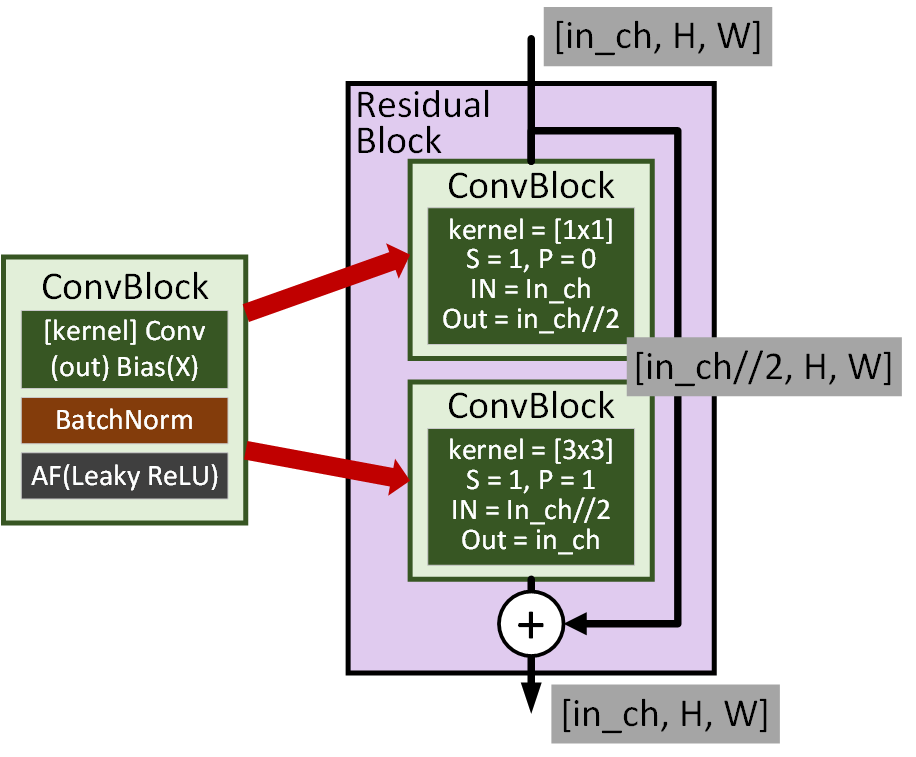

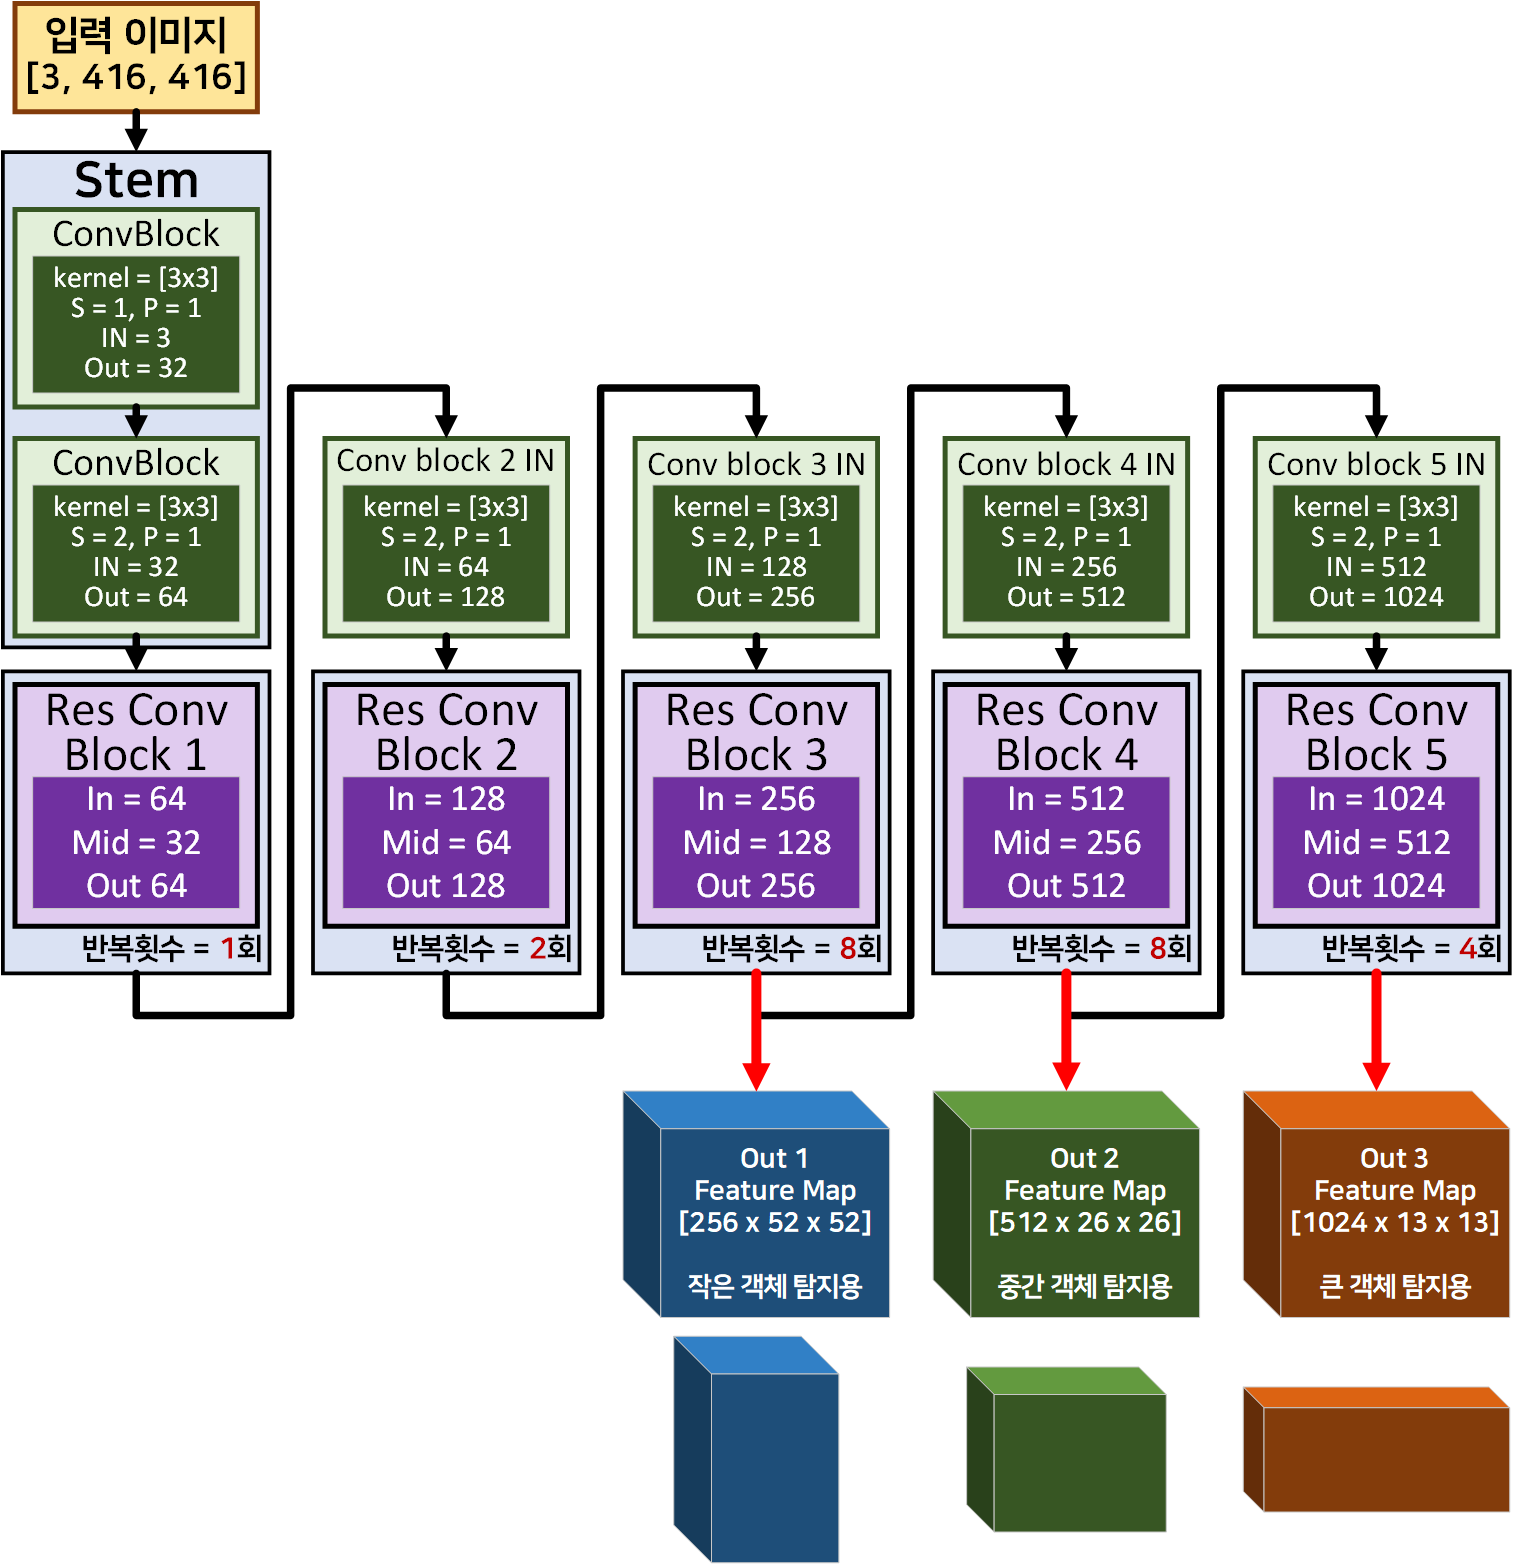

In [85]:
import torch
import torch.nn as nn
import numpy as np

In [86]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
            #conv2의 default stride=1, padding=0임을 잊지말자
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.1, inplace=False)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [87]:
class Residual_block(nn.Module):
    def __init__(self, in_channels, **kwargs):
        super(Residual_block, self).__init__()

        self.conv1 = BasicConv2d(in_channels, in_channels // 2, kernel_size=1)
        self.conv2 = BasicConv2d(in_channels // 2, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        out += identity
        return out

In [88]:
class Residual_block(nn.Module):
    def __init__(self, in_channels, **kwargs):
        super(Residual_block, self).__init__()

        self.conv1 = BasicConv2d(in_channels, in_channels // 2, kernel_size=1)
        self.conv2 = BasicConv2d(in_channels // 2, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        out += identity
        return out

In [89]:
class Darknet53(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000, pretrained=False):
        super(Darknet53, self).__init__()

        self.stem = nn.Sequential(
            BasicConv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            BasicConv2d(32, 64, kernel_size=3, stride=2, padding=1)
        )

        self.res_conv_1 = self._make_layer(64, 1)

        self.conv_2_in = BasicConv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.res_conv_2 = self._make_layer(128, 2)

        self.conv_3_in = BasicConv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.res_conv_3 = self._make_layer(256, 8)

        self.conv_4_in = BasicConv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.res_conv_4 = self._make_layer(512, 8)

        self.conv_5_in = BasicConv2d(512, 1024, kernel_size=3, stride=2, padding=1)
        self.res_conv_5 = self._make_layer(1024, 4)

        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1024, num_classes)
        )
        # pretrained 인자가 True일 경우 사전 학습된 가중치 로드
        if pretrained and '/content/drive/MyDrive/COCO_DATASET/DarkNet53.pth' is not None:
            self.load_state_dict(torch.load('/content/drive/MyDrive/COCO_DATASET/DarkNet53.pth'))

    #Res_conv_block를 반복해서 붙여넣을 때 사용되는 메서드
    def _make_layer(self, in_channels, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(Residual_block(in_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        f1 = self.res_conv_1(x)  # 1st level features

        x = self.conv_2_in(f1)
        f2 = self.res_conv_2(x)  # 2nd level features

        x = self.conv_3_in(f2)
        f3 = self.res_conv_3(x)  # 3rd level features

        x = self.conv_4_in(f3)
        f4 = self.res_conv_4(x)  # 4th level features

        x = self.conv_5_in(f4)
        f5 = self.res_conv_5(x)  # 5th level features

        features = [f3, f4, f5]

        return features

<>:30: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:30: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-89-b2d0a1d03db8>:30: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if pretrained and '/content/drive/MyDrive/COCO_DATASET/DarkNet53.pth' is not None:


In [90]:
from torchinfo import summary #모델의 요약정보 출력

model = Darknet53()

summary(model, input_size=(1, 3, 416, 416), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Darknet53                                [1, 256, 52, 52]          1,025,000
├─Sequential: 1-1                        [1, 64, 208, 208]         --
│    └─BasicConv2d: 2-1                  [1, 32, 416, 416]         --
│    │    └─Conv2d: 3-1                  [1, 32, 416, 416]         864
│    │    └─BatchNorm2d: 3-2             [1, 32, 416, 416]         64
│    │    └─LeakyReLU: 3-3               [1, 32, 416, 416]         --
│    └─BasicConv2d: 2-2                  [1, 64, 208, 208]         --
│    │    └─Conv2d: 3-4                  [1, 64, 208, 208]         18,432
│    │    └─BatchNorm2d: 3-5             [1, 64, 208, 208]         128
│    │    └─LeakyReLU: 3-6               [1, 64, 208, 208]         --
├─Sequential: 1-2                        [1, 64, 208, 208]         --
│    └─Residual_block: 2-3               [1, 64, 208, 208]         --
│    │    └─BasicConv2d: 3-7             [1, 32, 208, 208]         2,112

### DarkNet-53 사전학습 모델 적용

사전학습 모델 적용 코드 Github 주소 https://github.com/ayooshkathuria/pytorch-yolo-v3/blob/master/darknet.py

In [91]:
def parse_cfg(cfg_file):
    with open(cfg_file, 'r') as file:
        lines = file.read().split('\n')
        lines = [x for x in lines if x and not x.startswith('#')]
        lines = [x.rstrip().lstrip() for x in lines]

    block = {}
    blocks = []

    for line in lines:
        if line.startswith('['):
            if block:
                blocks.append(block)
                block = {}
            block['type'] = line[1:-1].rstrip()
        else:
            key, value = line.split('=')
            block[key.rstrip()] = value.lstrip()
    blocks.append(block)

    return blocks

In [92]:
class EmptyLayer(nn.Module):
    def forward(self, x):
        return x

In [93]:
class Darknet_cfg(nn.Module):
    def __init__(self, blocks):
        super(Darknet_cfg, self).__init__()
        self.blocks = blocks
        self.net_info, self.module_list = self.create_modules(blocks)

    def forward(self, x):
        outputs = {}
        for i, module in enumerate(self.module_list):
            module_type = self.blocks[i + 1]['type']

            if module_type in ["convolutional", "upsample", "maxpool"]:
                x = module(x)
            elif module_type == "route":
                layers = [int(a) for a in self.blocks[i + 1]["layers"].split(',')]
                if layers[0] > 0:
                    layers[0] = layers[0] - i
                if len(layers) == 1:
                    x = outputs[i + layers[0]]
                else:
                    if layers[1] > 0:
                        layers[1] = layers[1] - i
                    map1 = outputs[i + layers[0]]
                    map2 = outputs[i + layers[1]]
                    x = torch.cat((map1, map2), 1)
            elif module_type == "shortcut":
                from_layer = int(self.blocks[i + 1]["from"])
                x = outputs[i - 1] + outputs[i + from_layer]

            outputs[i] = x

        return x

    def create_modules(self, blocks):
        net_info = blocks[0]
        module_list = nn.ModuleList()
        prev_filters = 3
        output_filters = []

        for index, x in enumerate(blocks[1:]):
            module = nn.Sequential()

            if x['type'] == 'convolutional':
                activation = x['activation']
                try:
                    batch_normalize = int(x['batch_normalize'])
                    bias = False
                except:
                    batch_normalize = 0
                    bias = True

                filters = int(x['filters'])
                padding = int(x['pad'])
                kernel_size = int(x['size'])
                stride = int(x['stride'])

                if padding:
                    pad = (kernel_size - 1) // 2
                else:
                    pad = 0

                conv = nn.Conv2d(prev_filters, filters, kernel_size, stride, pad, bias=bias)
                module.add_module(f"conv_{index}", conv)

                if batch_normalize:
                    bn = nn.BatchNorm2d(filters)
                    module.add_module(f"batch_norm_{index}", bn)

                if activation == "leaky":
                    activn = nn.LeakyReLU(0.1, inplace=True)
                    module.add_module(f"leaky_{index}", activn)

            elif x['type'] == 'upsample':
                stride = int(x['stride'])
                upsample = nn.Upsample(scale_factor=stride, mode='bilinear', align_corners=True)
                module.add_module(f"upsample_{index}", upsample)

            elif x['type'] == 'route':
                x['layers'] = x['layers'].split(',')
                start = int(x['layers'][0])
                try:
                    end = int(x['layers'][1])
                except:
                    end = 0
                if start > 0:
                    start = start - index
                if end > 0:
                    end = end - index
                route = EmptyLayer()
                module.add_module(f"route_{index}", route)
                if end < 0:
                    filters = output_filters[index + start] + output_filters[index + end]
                else:
                    filters = output_filters[index + start]

            elif x['type'] == 'shortcut':
                shortcut = EmptyLayer()
                module.add_module(f"shortcut_{index}", shortcut)

            elif x['type'] == 'maxpool':
                stride = int(x['stride'])
                size = int(x['size'])
                maxpool = nn.MaxPool2d(size, stride)
                module.add_module(f"maxpool_{index}", maxpool)

            prev_filters = filters
            output_filters.append(filters)
            module_list.append(module)

        return (net_info, module_list)

In [94]:
def load_weights(model, weightfile):
    fp = open(weightfile, 'rb')
    header = np.fromfile(fp, dtype=np.int32, count=5)
    model.header = torch.from_numpy(header)
    model.seen = model.header[3]

    weights = np.fromfile(fp, dtype=np.float32)
    fp.close()

    ptr = 0
    for i, module in enumerate(model.module_list):
        module_type = model.blocks[i + 1]["type"]

        if module_type == "convolutional":
            conv_layer = module[0]
            # print(f"Loading weights for layer {i} of type {module_type}")

            if "batch_normalize" in model.blocks[i + 1]:
                bn_layer = module[1]
                num_b = bn_layer.bias.numel()
                # print(f"Batch norm layer: {num_b} biases, {num_b} weights, {num_b} running means, {num_b} running vars")
                bn_b = torch.from_numpy(weights[ptr:ptr + num_b]).view_as(bn_layer.bias)
                bn_layer.bias.data.copy_(bn_b)
                ptr += num_b
                bn_w = torch.from_numpy(weights[ptr:ptr + num_b]).view_as(bn_layer.weight)
                bn_layer.weight.data.copy_(bn_w)
                ptr += num_b
                bn_rm = torch.from_numpy(weights[ptr:ptr + num_b]).view_as(bn_layer.running_mean)
                bn_layer.running_mean.data.copy_(bn_rm)
                ptr += num_b
                bn_rv = torch.from_numpy(weights[ptr:ptr + num_b]).view_as(bn_layer.running_var)
                bn_layer.running_var.data.copy_(bn_rv)
                ptr += num_b
            else:
                num_b = conv_layer.bias.numel()
                # print(f"Conv layer: {num_b} biases")
                conv_b = torch.from_numpy(weights[ptr:ptr + num_b]).view_as(conv_layer.bias)
                conv_layer.bias.data.copy_(conv_b)
                ptr += num_b

            num_w = conv_layer.weight.numel()
            # print(f"Conv layer: {num_w} weights")
            conv_w = torch.from_numpy(weights[ptr:ptr + num_w]).view_as(conv_layer.weight)
            conv_layer.weight.data.copy_(conv_w)
            ptr += num_w

        if ptr >= len(weights):
            print("Finished loading weights")
            break
    return model

In [95]:
#Darknet53의 모델 설계정보를 파싱하는 함수
cfg_file = 'darknet53.cfg'
blocks = parse_cfg(cfg_file)

#파싱한 정보를 바탕으로 모델 복원하기
cfg_model = Darknet_cfg(blocks)

# 복원한 모델에 가중치 붙여넣기
weightfile = 'darknet53.weights'
cfg_model = load_weights(cfg_model, weightfile)
cfg_model

Finished loading weights


Darknet_cfg(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [96]:
summary(cfg_model, input_size=(1, 3, 416, 416), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Darknet_cfg                              [1, 1000, 13, 13]         --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 32, 416, 416]         --
│    │    └─Conv2d: 3-1                  [1, 32, 416, 416]         864
│    │    └─BatchNorm2d: 3-2             [1, 32, 416, 416]         64
│    │    └─LeakyReLU: 3-3               [1, 32, 416, 416]         --
│    └─Sequential: 2-2                   [1, 64, 208, 208]         --
│    │    └─Conv2d: 3-4                  [1, 64, 208, 208]         18,432
│    │    └─BatchNorm2d: 3-5             [1, 64, 208, 208]         128
│    │    └─LeakyReLU: 3-6               [1, 64, 208, 208]         --
│    └─Sequential: 2-3                   [1, 32, 208, 208]         --
│    │    └─Conv2d: 3-7                  [1, 32, 208, 208]         2,048
│    │    └─BatchNorm2d: 3-8             [1, 32, 208, 208]         64
│    │

In [97]:
# cfg_model의 가중치를 추출하여 사용이 용이한 모델에 붙여넣기
def transfer_weights(cfg_model, custom_model):
    cfg_params = list(cfg_model.named_parameters())
    custom_params = list(custom_model.named_parameters())

    for (name_cfg, param_cfg), (name_custom, param_custom) in zip(cfg_params, custom_params):
        if param_cfg.data.shape == param_custom.data.shape:
            param_custom.data = param_cfg.data.clone()
            # print(f"{name_cfg}의 레이어 파라미터를 {name_custom}로 전이")
        else:
            print(f"{name_cfg}레이어 파라미터를 {name_custom}에 붙여넣지 못함")

In [98]:
transfer_weights(cfg_model, model)

module_list.76.conv_76.weight레이어 파라미터를 fc.2.weight에 붙여넣지 못함


In [99]:
#전이 완료된 모델 저장하기
MODEL_NAME='DarkNet53'

torch.save(model.state_dict(), f'{MODEL_NAME}.pth')

### FPN

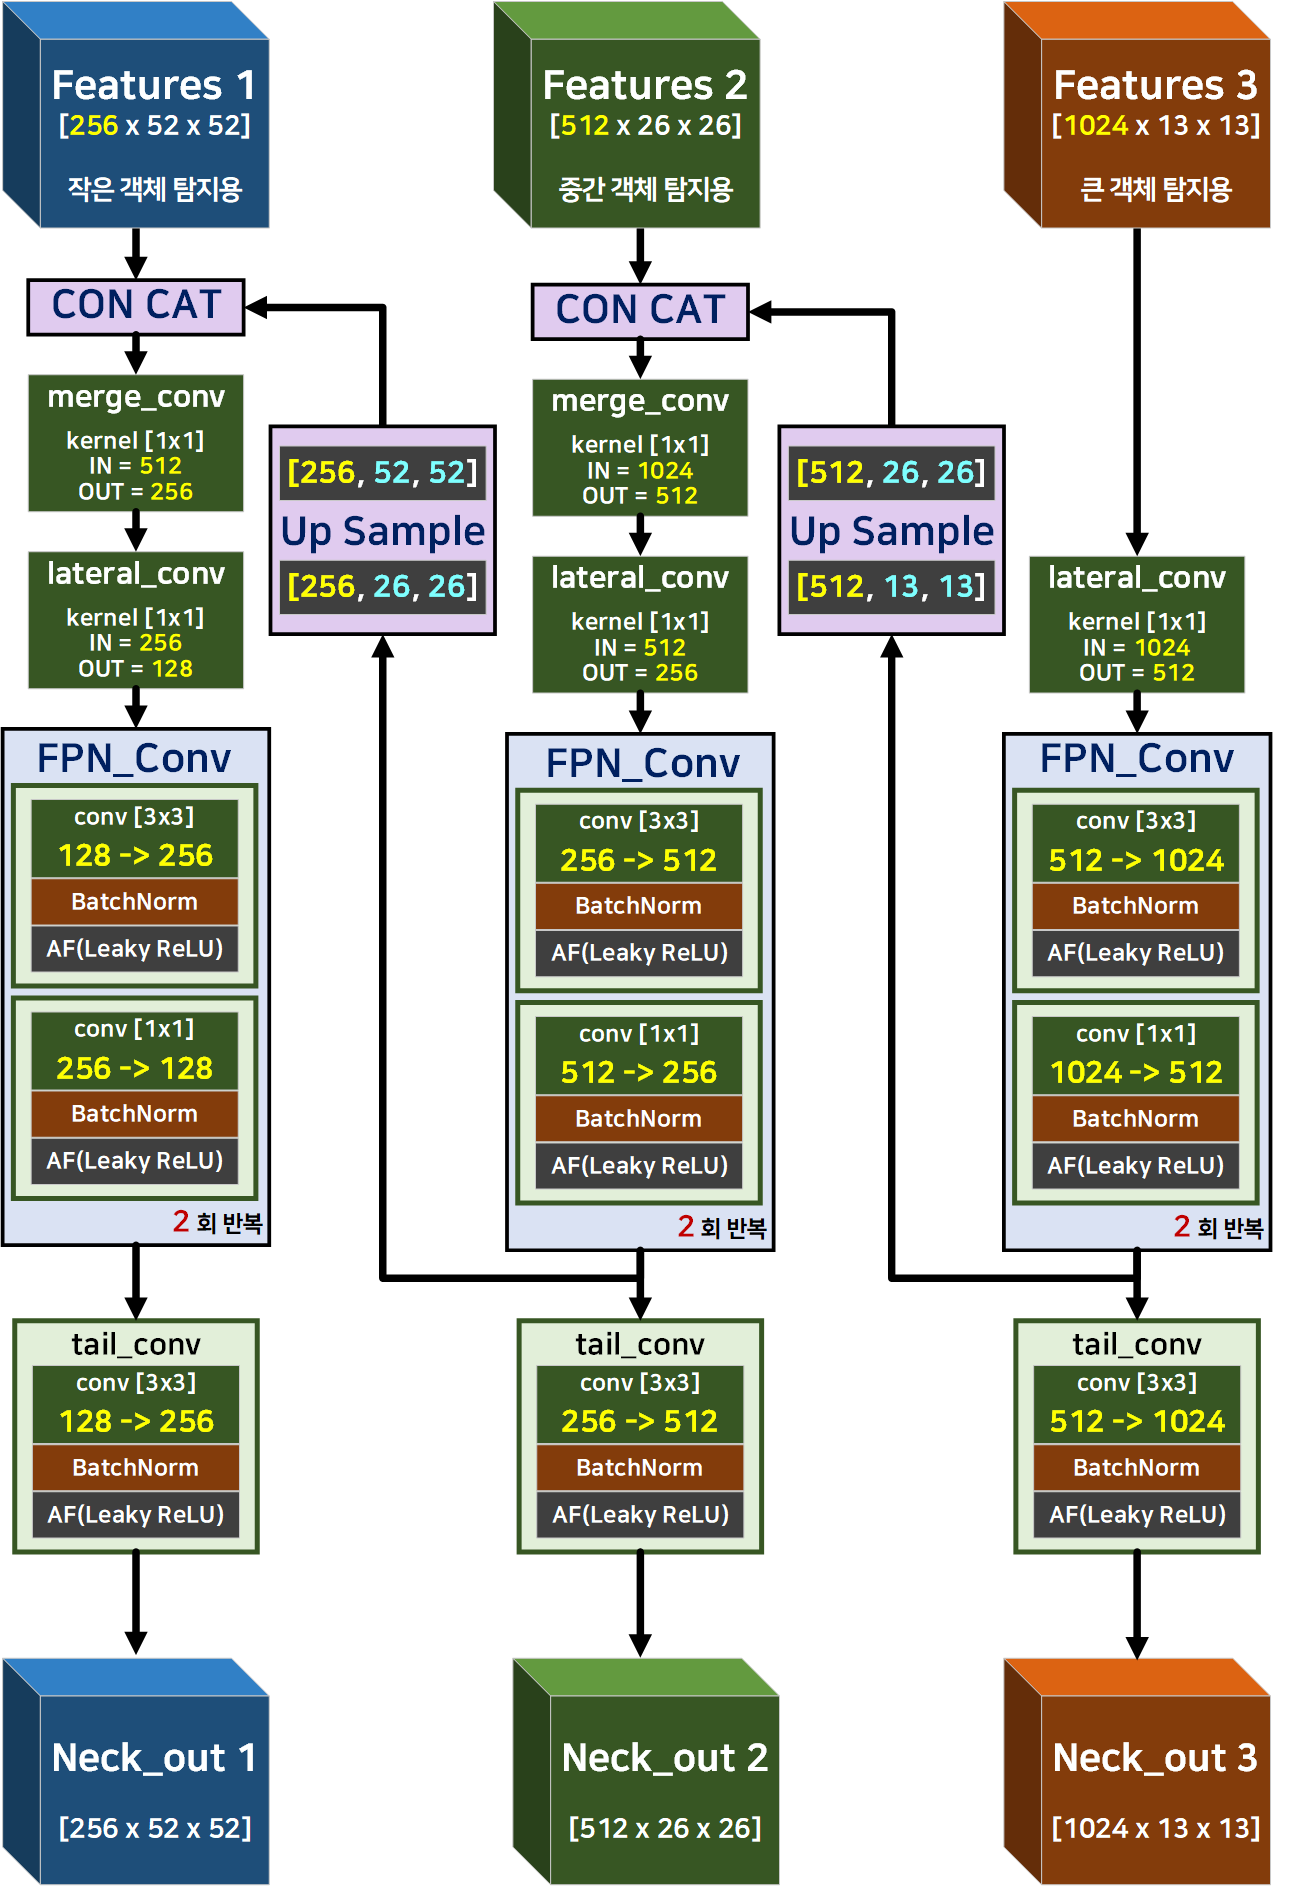

In [100]:
import torch.nn.functional as F

class FPN(nn.Module):
    def __init__(self, channels_list, num_repeats=2):
        super(FPN, self).__init__()
        self.lateral_convs = nn.ModuleList([
            nn.Conv2d(channels, channels//2, kernel_size=1)
            for channels in channels_list
        ])
        self.fpn_convs = nn.ModuleList([
            self._make_fpn_layers(channels, num_repeats)
            for channels in channels_list
        ])
        self.tail_convs = nn.ModuleList([
            BasicConv2d(channels // 2, channels, kernel_size=3, padding=1)
            for channels in channels_list
        ])
        self.merge_convs = nn.ModuleList([
            nn.Conv2d(channels_list[i] + channels_list[i+1]//2, channels_list[i]//2, kernel_size=1)
            for i in range(len(channels_list) - 1)
        ]) # channels_list[i+1]//2 연산 수행 후 channels_list[i]랑 덧셈되는 것

    def _make_fpn_layers(self, channels, num_repeats):
        layers = []
        for _ in range(num_repeats):
            layers.append(BasicConv2d(channels // 2, channels, kernel_size=3, padding=1))
            layers.append(BasicConv2d(channels, channels // 2, kernel_size=1))
        return nn.Sequential(*layers)

    def forward(self, *features):
        # 가변 위치인자 '*args'는 튜플로 처리되기에 리스트로 변환시킨다.
        features = list(features)
        # 첫번재 병렬 레이어 lateral_convs를 적용해 리스트 Feature Map : lateral_features 생성
        lateral_features = [lateral_conv(f) for lateral_conv, f in zip(self.lateral_convs, features)]
        # 두번째 병렬 레이어 fpn_convs를 적용해 리스트 fpn_features 피처맵 생성
        fpn_features = [fpn_conv(f) for fpn_conv, f in zip(self.fpn_convs, lateral_features)]

        # FPN의 Top-down pathway(상향경로) and aggregation(통합) 코드
        for i in range(len(fpn_features)-1, 0, -1):
            # 높은 레벨의 Featue를 낮은 레벨의 Featuer와 합성하기 위해 H, W를 Upsample
            upsampled = F.interpolate(fpn_features[i], scale_factor=2, mode='nearest')
            # 업 샘플된 높은 레벨의 Feature을 낮은 레벨의 Featuer와 Concat
            features[i-1] = torch.cat((features[i-1], upsampled), 1)
            # Concat한 신규 Feature을 차원축소(merge_convs) 하여 첫번째 병렬 레이어 업데이트
            lateral_features[i-1] = self.merge_convs[i-1](features[i-1])
            # 업데이트 된 첫번째 병렬 레이어 정보를 기반으로 두번째 병렬 레이어 업데이트
            fpn_features[i-1] = self.fpn_convs[i-1](lateral_features[i-1])

        # 가장 마지막 3번째 병렬 레이어에 Top-down pathway and aggregation이 적용된 Feature를 적용
        neck_out = [tail_conv(fpn_feature) for tail_conv, fpn_feature in zip(self.tail_convs, fpn_features)]

        return neck_out

In [101]:
in_1 = torch.rand(1, 256, 52, 52)
in_2 = torch.rand(1, 512, 26, 26)
in_3 = torch.rand(1, 1024, 13, 13)

features = [in_1, in_2, in_3]

# 예시 데이터를 기반으로 FPN의 인스턴스화
model = FPN(channels_list=[256, 512, 1024])

In [102]:
from torchinfo import summary
summary(model, input_data=features, col_names=("input_size", "output_size", "num_params"))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
FPN                                      [1, 256, 52, 52]          [1, 256, 52, 52]          --
├─ModuleList: 1-1                        --                        --                        --
│    └─Conv2d: 2-1                       [1, 256, 52, 52]          [1, 128, 52, 52]          32,896
│    └─Conv2d: 2-2                       [1, 512, 26, 26]          [1, 256, 26, 26]          131,328
│    └─Conv2d: 2-3                       [1, 1024, 13, 13]         [1, 512, 13, 13]          524,800
├─ModuleList: 1-6                        --                        --                        (recursive)
│    └─Sequential: 2-4                   [1, 128, 52, 52]          [1, 128, 52, 52]          --
│    │    └─BasicConv2d: 3-1             [1, 128, 52, 52]          [1, 256, 52, 52]          295,424
│    │    └─BasicConv2d: 3-2             [1, 256, 52, 52]          [1, 128, 52, 52]          33,024
│  

In [103]:
fpn_features = model(*features)

# upsampled의 shape 출력
for i in range(len(fpn_features)):
    print("Upsampled shape:", fpn_features[i].shape)

Upsampled shape: torch.Size([1, 256, 52, 52])
Upsampled shape: torch.Size([1, 512, 26, 26])
Upsampled shape: torch.Size([1, 1024, 13, 13])


### Head

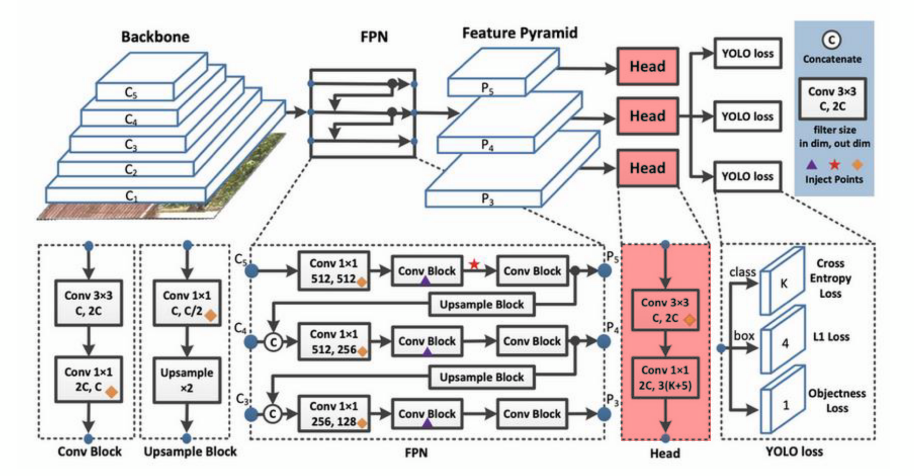

In [104]:
class YOLOHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(YOLOHead, self).__init__()
        self.conv = nn.Conv2d(in_channels, 3 * (5 + num_classes), kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [105]:
# 백본 모델 인스턴스 생성
backbone = Darknet53()
# 임의의 입력 텐서 생성 및 모델에 통과시킴
input_tensor = torch.rand(1, 3, 416, 416)
features = backbone(input_tensor)
# 각 레이어의 출력 shape 정보에서 채널 수만 추출하여 리스트에 저장
features_shape = [feature.shape[1] for feature in features]
features_shape

[256, 512, 1024]

### YOLOv3

In [106]:
class YOLOv3(nn.Module):
    def __init__(self, backbone, fpn, num_classes):
        super(YOLOv3, self).__init__()
        self.backbone = backbone
        self.fpn = fpn
        self.num_classes = num_classes

        self.heads = nn.ModuleList([
            YOLOHead(in_channels, num_classes) for in_channels in features_shape
        ])

    def forward(self, x):
        features = self.backbone(x)
        fpn_features = self.fpn(*features)
        outputs = [head(fpn_feature) for head, fpn_feature in zip(self.heads, fpn_features)]
        return outputs

In [107]:
backbone = Darknet53(pretrained=True)
fpn = FPN(channels_list=features_shape)
yolov3 = YOLOv3(backbone, fpn, num_classes=80)

In [108]:
# 백본 파라미터 Freeze
for param in backbone.parameters():
    param.requires_grad = False

In [109]:
from torchinfo import summary
# Use torchinfo to summarize the model
summary(yolov3, input_size=(1, 3, 416, 416))

Layer (type:depth-idx)                        Output Shape              Param #
YOLOv3                                        [1, 255, 52, 52]          --
├─Darknet53: 1-1                              [1, 256, 52, 52]          1,025,000
│    └─Sequential: 2-1                        [1, 64, 208, 208]         --
│    │    └─BasicConv2d: 3-1                  [1, 32, 416, 416]         (928)
│    │    └─BasicConv2d: 3-2                  [1, 64, 208, 208]         (18,560)
│    └─Sequential: 2-2                        [1, 64, 208, 208]         --
│    │    └─Residual_block: 3-3               [1, 64, 208, 208]         (20,672)
│    └─BasicConv2d: 2-3                       [1, 128, 104, 104]        --
│    │    └─Conv2d: 3-4                       [1, 128, 104, 104]        (73,728)
│    │    └─BatchNorm2d: 3-5                  [1, 128, 104, 104]        (256)
│    │    └─LeakyReLU: 3-6                    [1, 128, 104, 104]        --
│    └─Sequential: 2-4                        [1, 128, 104, 104]

In [110]:
input = torch.rand(1, 3, 416, 416).to(device)
# 출력물 검증해보기
output = yolov3(input)

In [111]:
for i in range(len(output)):
    print(output[i].shape)

torch.Size([1, 255, 52, 52])
torch.Size([1, 255, 26, 26])
torch.Size([1, 255, 13, 13])


### YOLOv3 Loss

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class Yolov3Loss(nn.Module):
    def __init__(self, B=3, C=80):
        super(Yolov3Loss, self).__init__()
        # self.S = S # 그리드셀의 단위(52, 26, 13)
        self.B = B # 이 값은 Anchor box의 개수로 인자 변환
        self.C = C # class종류(Coco 데이터 기준 80)
        self.lambda_coord = 5   # 실험적으로 구한 계수값
        self.lambda_noobj = 0.5 # 실험적으로 구한 계수값
        # Objectness loss 및 Classification Loss는 SSE에서 BCE로 변경
        self.bce_loss = nn.BCELoss(reduction='sum')

    def forward(self, predictions, target):
        # Assert 구문을 활용하여 grid cell의 크기가 동일한지 확인
        assert predictions.size(1) == predictions.size(2), "그리드셀 차원이 맞지 않음"

        batch_size = predictions.size(0) # Batch_size의 사이즈 정보를 추출
        S = predictions.size(2) # grid cell의 개수 정보를 추출
        # [Batch_size, S, S, (5 + C) * B] ->  [Batch_size, S, S, B, (5 + C)]로 변환
        predictions = predictions.view(batch_size, S, S, self.B, 5 + self.C)
        target = target.view(batch_size, S, S, self.B, 5 + self.C)

        # 2) BBox좌표, OS, CS 정보 추출하여 재배치
        pred_boxes = predictions[..., :4] # [batch_size, S, S, B, 4]
        # target_boxex의 추출된 정보는 [sigtx, sig, ty, tw, th]이니
        # 이것에 맞게 pred_boxe의 [tx, ty]도 [sigmoid(tx), sigmoid(ty)]처리
        pred_boxes[..., :2] = torch.sigmoid(pred_boxes[..., :2])
        # pred_boxes[..., :2] = torch.clamp(pred_boxes[..., :2], self.e, 1-self.e)
        target_boxes = target[..., :4] # [batch_size, S, S, B, 4]

        pred_obj = torch.sigmoid(predictions[..., 4])
        target_obj = target[..., 4]  # [batch_size, S, S, B]

        # Class scores에 sigmoid 적용 -> 이게 Yolo v3의 핵심임
        pred_class = torch.sigmoid(predictions[..., 5:])   # [batch_size, S, S, B]
        target_class = target[..., 5:] # [batch_size, S, S, B, C]

        # 3) 마스크 필터 생성
        coord_mask = target_obj > 0 # [batch_size, S, S, B]
        noobj_mask = target_obj <= 0 # [batch_size, S, S, B]
        # 예외처리 : 객체가 아에 없는 이미지에 대한
        if coord_mask.sum() == 0:
            return torch.tensor(0.0, requires_grad=True)

        # 4) 마스크 필터를 적용해 Bbox의 데이터 필터링
        # unsqueeze를 이용해 [batch_size, S, S, B] -> [batch_size, S, S, B, 1]
        # 이후 expand_as를 이용해 [batch_size, S, S, B, 4]
        # expand_as는 expand랑 거의 기능이 같다
        coord_mask_box = coord_mask.unsqueeze(-1).expand_as(target_boxes)

        # 5) Localization Loss 계산하기
        # bbox의 값이 [tx, ty, tw, th]이니 한꺼번에 loss 계산
        coord_loss = self.lambda_coord * (
            (pred_boxes[coord_mask_box] - target_boxes[coord_mask_box]) ** 2
        ).sum()

        # 6) OS(objectness Score)의 마스크 필터를 활용한 필터링
        # 7) Objectness Loss 계산하기
        obj_loss = self.bce_loss(pred_obj[coord_mask], target_obj[coord_mask])

        cal = self.bce_loss(pred_obj[noobj_mask], target_obj[noobj_mask])
        noobj_loss = self.lambda_noobj * cal

        # 8) CP(Class Probabilities)에 대한 필터링 작업
        # 9) Classification Loss 계산하기
        # coord_mask는 자동으로 broadcasting이 되어서 expand_as를 안써도 된다.
        class_loss = self.bce_loss(pred_class[coord_mask], target_class[coord_mask])

        total_loss = coord_loss + obj_loss + noobj_loss + class_loss

        return total_loss

In [ ]:
# 예시: YOLOv3 모델의 출력값 (3개 스케일)
output_1 = torch.rand(1, 52, 52, 255)
output_2 = torch.rand(1, 26, 26, 255)
output_3 = torch.rand(1, 13, 13, 255)

# 타겟 텐서도 예시로 생성
target_1 = torch.rand(1, 52, 52, 255)
target_2 = torch.rand(1, 26, 26, 255)
target_3 = torch.rand(1, 13, 13, 255)

In [ ]:
# YOLOv3 손실 함수 인스턴스 생성
yolov3_loss = Yolov3Loss(B=3, C=80)  # B와 C 값 설정

In [ ]:
# 각 출력값과 타겟값에 대해 손실 계산
loss_1 = yolov3_loss(output_1, target_1)
loss_2 = yolov3_loss(output_2, target_2)
loss_3 = yolov3_loss(output_3, target_3)

In [ ]:
loss_1,loss_2,loss_3

(tensor(504011.2500), tensor(125999.1562), tensor(31594.1543))

### COCO data 확인


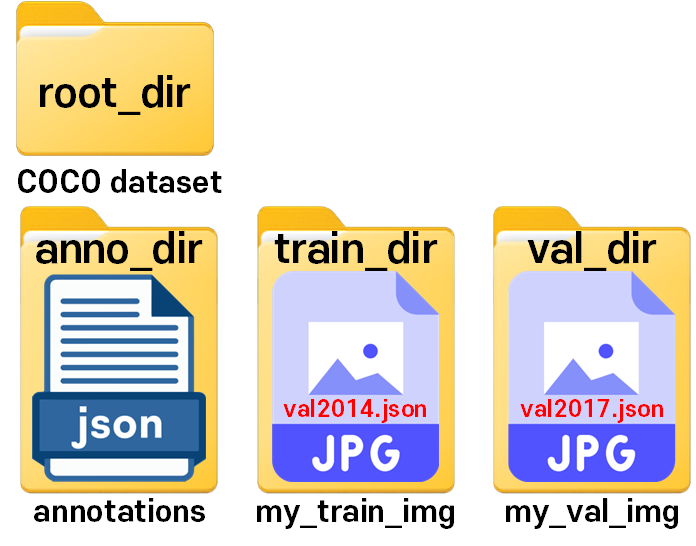

In [43]:
import os
import json
import torch
from pycocotools.coco import COCO
from torch.utils.data import Dataset
from PIL import Image

In [44]:
root_dir = '/content/drive/MyDrive/COCO_DATASET'
anno_file = 'annotations/instances_val2014.json'
anno = COCO(os.path.join(root_dir, anno_file))

loading annotations into memory...
Done (t=13.05s)
creating index...
index created!


In [ ]:
anno.getAnnIds()

[156,
 509,
 603,
 918,
 1072,
 1727,
 1728,
 1767,
 1768,
 1769,
 1773,
 1774,
 2144,
 2251,
 2255,
 2259,
 2280,
 2281,
 2496,
 2498,
 2500,
 2526,
 2532,
 2534,
 2544,
 2551,
 3003,
 3165,
 3186,
 3212,
 3323,
 3375,
 3419,
 3488,
 3658,
 3692,
 3817,
 4047,
 4061,
 4079,
 4254,
 4430,
 4474,
 4594,
 4654,
 4703,
 4893,
 4932,
 4940,
 5037,
 5181,
 5544,
 5560,
 5585,
 5623,
 5637,
 5652,
 5812,
 6099,
 6104,
 6172,
 6174,
 6259,
 6656,
 7023,
 7064,
 7158,
 7178,
 7228,
 7287,
 7305,
 7319,
 7486,
 7514,
 7544,
 7588,
 7670,
 7793,
 7880,
 7910,
 7915,
 7981,
 8000,
 8032,
 8084,
 8442,
 8715,
 8721,
 8793,
 8807,
 8915,
 8989,
 9022,
 9024,
 9031,
 9040,
 9065,
 9120,
 9155,
 9280,
 9417,
 9553,
 9626,
 9657,
 9819,
 9940,
 10032,
 10071,
 10176,
 10187,
 10385,
 10442,
 10449,
 10527,
 10600,
 10750,
 11070,
 11097,
 11207,
 11272,
 11290,
 11381,
 11491,
 11554,
 11571,
 11592,
 11640,
 11650,
 11660,
 11682,
 11706,
 11840,
 11970,
 12030,
 12047,
 12182,
 12282,
 12414,
 12543

In [ ]:
anno.getImgIds()

[391895,
 522418,
 184613,
 318219,
 554625,
 397133,
 574769,
 60623,
 309022,
 5802,
 222564,
 118113,
 193271,
 224736,
 483108,
 403013,
 374628,
 328757,
 384213,
 293802,
 86408,
 37777,
 372938,
 386164,
 223648,
 204805,
 113588,
 384553,
 337264,
 368402,
 12448,
 252219,
 79841,
 87038,
 174482,
 515289,
 562150,
 542145,
 412151,
 403385,
 579003,
 540186,
 242611,
 51191,
 269105,
 294832,
 462565,
 144941,
 173350,
 60760,
 324266,
 166532,
 262284,
 360772,
 6818,
 191381,
 111076,
 340559,
 258985,
 509822,
 321107,
 229643,
 125059,
 455483,
 436141,
 129001,
 232262,
 61181,
 166323,
 580041,
 326781,
 387362,
 138079,
 556616,
 472621,
 192440,
 86320,
 256668,
 383445,
 565797,
 81922,
 50125,
 364521,
 394892,
 1146,
 310391,
 97434,
 463836,
 241876,
 156832,
 480985,
 458054,
 270721,
 462341,
 310103,
 32992,
 122851,
 540763,
 331352,
 138246,
 197254,
 32907,
 251252,
 37675,
 159537,
 268556,
 271177,
 75051,
 549399,
 85160,
 559665,
 296649,
 19358,
 459912,

In [ ]:
anno.getCatIds()

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 27,
 28,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 67,
 70,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 84,
 85,
 86,
 87,
 88,
 89,
 90]

In [ ]:
len(anno.getCatIds())

80

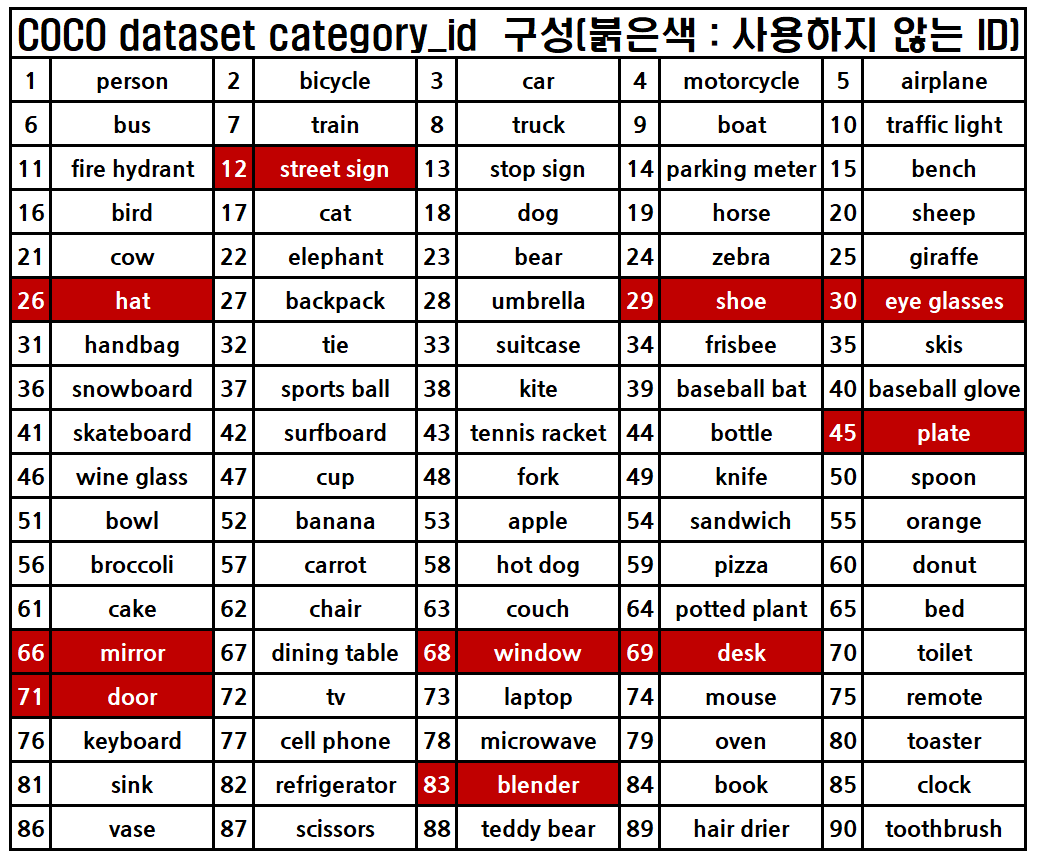

In [ ]:
anno.getImgIds()[20]

86408

In [ ]:
img_info = anno.loadImgs(anno.getImgIds()[20])[0]
img_info

{'license': 1,
 'file_name': 'COCO_val2014_000000086408.jpg',
 'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000086408.jpg',
 'height': 427,
 'width': 640,
 'date_captured': '2013-11-14 20:29:23',
 'flickr_url': 'http://farm4.staticflickr.com/3668/9463610705_130c967a7b_z.jpg',
 'id': 86408}

In [ ]:
img_dir = os.path.join(root_dir, 'my_train_img')
img_dir

'/content/drive/MyDrive/COCO_DATASET/my_train_img'

In [ ]:
img_path = os.path.join(img_dir,img_info['file_name'])
img_path

'/content/drive/MyDrive/COCO_DATASET/my_train_img/COCO_val2014_000000086408.jpg'

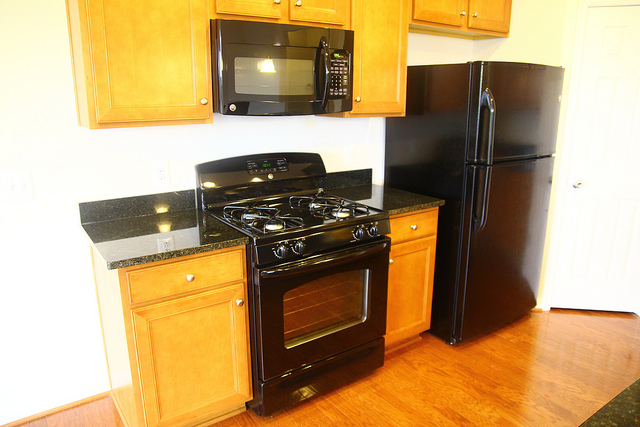

In [ ]:
test_img = Image.open(img_path)
test_img

In [ ]:
img_info['id']

86408

In [ ]:
ann_ids = anno.getAnnIds(imgIds=img_info['id'])
ann_ids

[331640, 1118402, 1121156]

In [ ]:
annotations = anno.loadAnns(ann_ids)

{k: v for k, v in annotations[0].items() if k != 'segmentation'}

{'area': 36156.022950000006,
 'iscrowd': 0,
 'image_id': 86408,
 'bbox': [384.68, 62.99, 182.73, 284.67],
 'category_id': 82,
 'id': 331640}

In [ ]:
annotations[0]['bbox']

[384.68, 62.99, 182.73, 284.67]

In [ ]:
test_img.size

(640, 427)

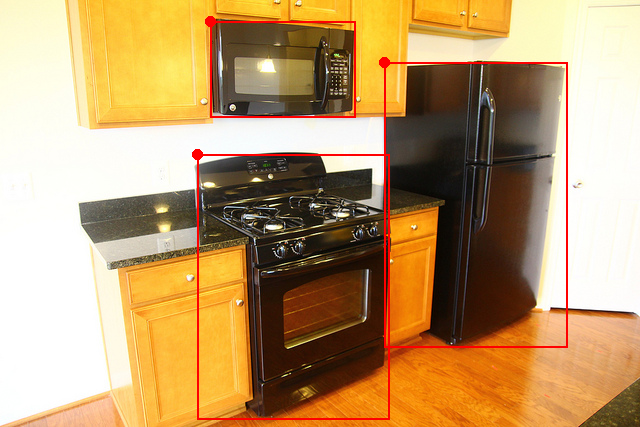

In [ ]:
from PIL import Image, ImageDraw
draw = ImageDraw.Draw(test_img)
point_size = 5  # 점의 크기

for annotation in annotations:
    bbox = annotation['bbox']
    draw.ellipse((bbox[0] - point_size, bbox[1] - point_size, bbox[0] + point_size, bbox[1] + point_size), fill='red')
    draw.rectangle([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]], outline='red', width=2)
test_img

### K-means Clustering

In [112]:
# 사용되지 않는 category_id를 제외한 딕셔너리 생성
used_categories = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
    23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
    46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
    65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88,
    89, 90
]

real_class_idx = {cat_id: idx for idx, cat_id in enumerate(used_categories)}
real_class_idx

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 13: 11,
 14: 12,
 15: 13,
 16: 14,
 17: 15,
 18: 16,
 19: 17,
 20: 18,
 21: 19,
 22: 20,
 23: 21,
 24: 22,
 25: 23,
 27: 24,
 28: 25,
 31: 26,
 32: 27,
 33: 28,
 34: 29,
 35: 30,
 36: 31,
 37: 32,
 38: 33,
 39: 34,
 40: 35,
 41: 36,
 42: 37,
 43: 38,
 44: 39,
 46: 40,
 47: 41,
 48: 42,
 49: 43,
 50: 44,
 51: 45,
 52: 46,
 53: 47,
 54: 48,
 55: 49,
 56: 50,
 57: 51,
 58: 52,
 59: 53,
 60: 54,
 61: 55,
 62: 56,
 63: 57,
 64: 58,
 65: 59,
 67: 60,
 70: 61,
 72: 62,
 73: 63,
 74: 64,
 75: 65,
 76: 66,
 77: 67,
 78: 68,
 79: 69,
 80: 70,
 81: 71,
 82: 72,
 84: 73,
 85: 74,
 86: 75,
 87: 76,
 88: 77,
 89: 78,
 90: 79}

In [113]:
S_list = [52, 26, 13]
label_matrix = [
            torch.zeros((S, S, 80+5)) for S in S_list
        ]
label_matrix[1].shape

torch.Size([26, 26, 85])

In [114]:
# 사용되지 않는 category_id를 제외한 딕셔너리 생성
used_categories = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
    23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
    46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
    65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88,
    89, 90
]

real_class_idx = {cat_id: idx for idx, cat_id in enumerate(used_categories)}
class CustomDataset(Dataset):
    def __init__(self, root, img_set=None, transform=None,
                 S=[52, 26, 13], B=3, C=80,
                 anchor = None):
        self.root = root #COCO 데이터셋의 메인 폴더 경로

        self.img_set = img_set
        self.transform = transform
        self.S_list = S # Gird Cell사이즈 -> [13, 26, 52] -> 인자값으로 받기
        self.B = B # anchorbox의 개수 : 3
        self.C = C # COCO데이터셋의 클래스 개수 : 80

        # Anchor_box_list를 관리하기 위한 변수
        self.anchor = anchor

        self.anno_path = os.path.join(root, 'annotations')

        if img_set == 'train':
            self.img_dir = os.path.join(root, 'my_train_img')
            self.coco = COCO(os.path.join(self.anno_path, 'instances_val2014.json'))
        elif img_set == 'val':
            self.img_dir = os.path.join(root, 'my_val_img')
            self.coco = COCO(os.path.join(self.anno_path, 'instances_val2017.json'))
        elif img_set == 'test':
            pass
        else:
            raise ValueError("이미지 모드 확인하기")

        # 모드별 이미지 ID리스트 불러오기
        self.img_ids = self.coco.getImgIds()

    def __len__(self):
        return len(self.img_ids)

    #예의 바르게 해당 클래스의 실행 결과를 불러오자
    def __str__(self):
        if len(self.img_ids) == 0:
            message = f"Img 폴더 내 파일 못찾음"
        else:
            message = f"Img 폴더 찾은 *.jpg 개수: {len(self.img_ids)}"
        return f"{message}"

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        # ann_ids는 불러온 이미지와 관련된 Anno 리스트를 가져온다
        anns = self.coco.loadAnns(ann_ids)

        # 이미지의 기본 정보 추출하기 -> [0]붙이는거 까먹지말자
        img_info = self.coco.loadImgs(img_id)[0]
        # 찾은 이미지에 맞는 파일이름을 찾아서 출력할 Image에 할당
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")

        # 라벨 메트릭스 생성 [S, S, C+5=85]로 생성을 먼저함
        label_matrix = [
            torch.zeros((S, S, self.C+5)) for S in self.S_list
        ]
        # 이제 Anno주석정보를 라벨 매트릭스에 기입하기
        for ann in anns:
            bbox = ann['bbox']
            # CP는 Class Probability이니 = Class ID
            CP_idx = real_class_idx[ann['category_id']]

            x, y, w, h = bbox
            # bbox 좌표 정규화
            bx = (x + w / 2) / img_info['width']
            by = (y + h / 2) / img_info['height']
            bw = w / img_info['width']
            bh = h / img_info['height']

            #정규좌표평면에서 center point가 위치하는 그리드셀 탐색
            for i, S in enumerate(self.S_list):
                # 정규화된 좌표평면 상에서 grid_y, x의 idx를 구해야 한다.
                grid_x = int(bx * S)
                grid_y = int(by * S)

                #탐색한 그리드셀이 비어있으면 아래 정보 기입
                if label_matrix[i][grid_y, grid_x, 4] == 0:
                    # OS(Objectness Score) 정보 기입
                    label_matrix[i][grid_y, grid_x, 4] = 1
                    # BBox(bx, by, bw, bh) 정보 기입
                    label_matrix[i][grid_y, grid_x, :4] = torch.tensor(
                        [bx, by, bw, bh]
                    )
                    # CP(Class Probability) 정보 기입
                    label_matrix[i][grid_y, grid_x, 5 + CP_idx] = 1

        # 이미지의 전처리 방법론이 수행될 때 label matrix도 같이 업데이트
        if self.transform:
            image = self.transform(image)

        return image, tuple(label_matrix)

In [115]:
# 위 CustomDataset의 인스턴스화
train_dataset = CustomDataset(root=root_dir, img_set='train')
test_dataset = CustomDataset(root=root_dir, img_set='val')

loading annotations into memory...
Done (t=8.77s)
creating index...
index created!
loading annotations into memory...
Done (t=1.44s)
creating index...
index created!


In [116]:
print(train_dataset, test_dataset)

Img 폴더 찾은 *.jpg 개수: 40504 Img 폴더 찾은 *.jpg 개수: 5000


In [117]:
img, labels = train_dataset[0]

print(type(labels))
for label in labels:
    print(label.shape)

<class 'tuple'>
torch.Size([52, 52, 85])
torch.Size([26, 26, 85])
torch.Size([13, 13, 85])


In [118]:
import numpy as np
from sklearn.cluster import KMeans
from tqdm import tqdm #훈련 진행상황 체크

In [119]:
# 모든 bbox 정보를 추출하는 함수
def extract_bboxes(dataset):
    bboxes = []
    for i in tqdm(range(len(dataset))):
        # 커스텀데이터셋은 리턴이 img, label이니 img는 뺀다.
        _, label_matrix = dataset[i]
        for S_idx, S in enumerate(dataset.S_list):
            label_mat = label_matrix[S_idx]
            # OS정보가 1인 값만 필터링
            obj_indices = (label_mat[..., 4] == 1).nonzero(as_tuple=True)
            # 필터링 후 [bx, by, bw, bh]에서 bw, bh만 추출
            if len(obj_indices[0]) > 0:
                bboxes.extend(label_mat[obj_indices][:, 2:4].tolist())

    return np.array(bboxes)

In [120]:
#bbox 정보 추출
# bboxes = extract_bboxes(train_dataset)
# print(f"Extracted {len(bboxes)} bounding boxes")

In [121]:
# bboxes를 numpy 파일로 저장
# np.save('bboxes.npy', bboxes)

In [122]:
bboxes = np.load('bboxes.npy')

In [123]:
bboxes.shape

(812184, 2)

In [124]:
# k-means 클러스터링을 수행하여 9개의 anchor box 추출
kmeans = KMeans(n_clusters=9, random_state=42, n_init='auto').fit(bboxes)
anchors = kmeans.cluster_centers_
anchors

array([[0.38464032, 0.83243351],
       [0.0430459 , 0.05774691],
       [0.37007827, 0.23355614],
       [0.84938177, 0.36934118],
       [0.87748422, 0.85986112],
       [0.14489405, 0.31324601],
       [0.22235841, 0.5389649 ],
       [0.12087719, 0.1486785 ],
       [0.52990178, 0.53865267]])

In [125]:
areas = anchors[:, 0] * anchors[:, 1]
areas

array([0.32018749, 0.00248577, 0.08643405, 0.31371167, 0.75451457,
       0.04538748, 0.11984338, 0.01797184, 0.28543301])

In [126]:
sorted_indices = np.argsort(areas)
sorted_indices

array([1, 7, 5, 2, 6, 8, 3, 0, 4])

In [127]:
# Anchor boxes를 크기 순으로 정렬
areas = anchors[:, 0] * anchors[:, 1]
sorted_indices = np.argsort(areas)

sorted_anchors = anchors[sorted_indices]
print(sorted_anchors)

[[0.0430459  0.05774691]
 [0.12087719 0.1486785 ]
 [0.14489405 0.31324601]
 [0.37007827 0.23355614]
 [0.22235841 0.5389649 ]
 [0.52990178 0.53865267]
 [0.84938177 0.36934118]
 [0.38464032 0.83243351]
 [0.87748422 0.85986112]]


In [128]:
reshape_anchors = sorted_anchors.reshape(3,3,-1)
reshape_anchors

array([[[0.0430459 , 0.05774691],
        [0.12087719, 0.1486785 ],
        [0.14489405, 0.31324601]],

       [[0.37007827, 0.23355614],
        [0.22235841, 0.5389649 ],
        [0.52990178, 0.53865267]],

       [[0.84938177, 0.36934118],
        [0.38464032, 0.83243351],
        [0.87748422, 0.85986112]]])

In [129]:
# 아래의 값은 단순히 시각적으로 4자리만 표시된 것 뿐임
anchor_box_list = torch.tensor(reshape_anchors)
anchor_box_list

tensor([[[0.04304590, 0.05774691],
         [0.12087719, 0.14867850],
         [0.14489405, 0.31324601]],

        [[0.37007827, 0.23355614],
         [0.22235841, 0.53896490],
         [0.52990178, 0.53865267]],

        [[0.84938177, 0.36934118],
         [0.38464032, 0.83243351],
         [0.87748422, 0.85986112]]], dtype=torch.float64)

In [130]:
# set_printoptions 함수를 통해 더 자세한 값까지 확인이 가능하다
torch.set_printoptions(precision=8)
anchor_box_list

tensor([[[0.04304590, 0.05774691],
         [0.12087719, 0.14867850],
         [0.14489405, 0.31324601]],

        [[0.37007827, 0.23355614],
         [0.22235841, 0.53896490],
         [0.52990178, 0.53865267]],

        [[0.84938177, 0.36934118],
         [0.38464032, 0.83243351],
         [0.87748422, 0.85986112]]], dtype=torch.float64)

In [131]:
set(kmeans.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8}

In [132]:
labels = kmeans.labels_
labels

array([0, 7, 1, ..., 7, 7, 7], dtype=int32)

<ipython-input-133-a06943ab0ee7>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 9)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


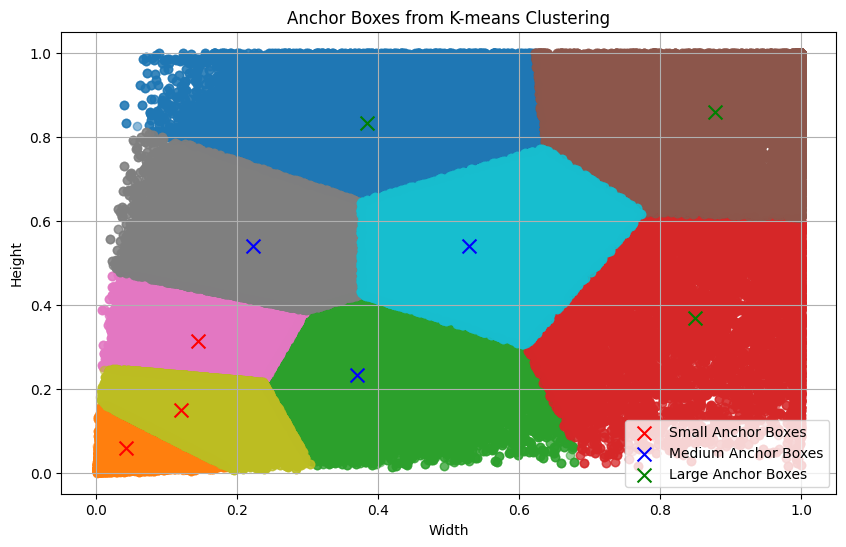

In [133]:
import numpy as np
import matplotlib.pyplot as plt

# 그래프 시각화
colors = plt.cm.get_cmap('tab10', 9)
plt.figure(figsize=(10, 6))
for i in range(9):
    plt.scatter(bboxes[labels == i, 0], bboxes[labels == i, 1], color=colors(i), marker='o', alpha=0.5)
plt.scatter(sorted_anchors[:3, 0], sorted_anchors[:3, 1], c='red', marker='x', s=100, label='Small Anchor Boxes')
plt.scatter(sorted_anchors[3:6, 0], sorted_anchors[3:6, 1], c='blue', marker='x', s=100, label='Medium Anchor Boxes')
plt.scatter(sorted_anchors[6:9, 0], sorted_anchors[6:9, 1], c='green', marker='x', s=100, label='Large Anchor Boxes')

plt.title('Anchor Boxes from K-means Clustering')
plt.xlabel('Width')
plt.ylabel('Height')
plt.legend()
plt.grid(True)
plt.show()

### COCO Dataset

In [66]:
class CustomDataset(Dataset):
    def __init__(self, root, img_set=None, transform=None,
                 S=[52, 26, 13], B=3, C=80,
                 anchor = None):
        self.root = root #COCO 데이터셋의 메인 폴더 경로

        self.img_set = img_set
        self.transform = transform
        self.S_list = S # Gird Cell사이즈 -> [13, 26, 52] -> 인자값으로 받기
        self.B = B # anchorbox의 개수 : 3
        self.C = C # COCO데이터셋의 클래스 개수 : 80

        # Anchor_box_list를 관리하기 위한 변수
        self.anchor = anchor

        self.anno_path = os.path.join(root, 'annotations')

        if img_set == 'train':
            self.img_dir = os.path.join(root, 'my_train_img')
            self.coco = COCO(os.path.join(self.anno_path, 'instances_val2014.json'))
        elif img_set == 'val':
            self.img_dir = os.path.join(root, 'my_val_img')
            self.coco = COCO(os.path.join(self.anno_path, 'instances_val2017.json'))
        elif img_set == 'test':
            pass
        else:
            raise ValueError("이미지 모드 확인하기")

        # 모드별 이미지 ID리스트 불러오기
        self.img_ids = self.coco.getImgIds()

    def __len__(self):
        return len(self.img_ids)

    #예의 바르게 해당 클래스의 실행 결과를 불러오자
    def __str__(self):
        if len(self.img_ids) == 0:
            message = f"Img 폴더 내 파일 못찾음"
        else:
            message = f"Img 폴더 찾은 *.jpg 개수: {len(self.img_ids)}"
        return f"{message}"

    # label matrix의 [b*x, b*y, b*w, b*h]를 [t*x, t*y, t*w, t*h]로 변환하는 코드
    def _reverse_gt_bbox(self, b_bbox, anchor, cell_idx, S):
        if self.anchor is None:
            raise ValueError("앵커박스 정보가 없음")

        # [b*x, b*y, b*w, b*h]는 0~1범위로 스케일링 되었으니
        # 시그모이드 역함수를 적용하지 않아도 된다.
        bx, by, bw, bh = b_bbox
        pw, ph = anchor
        # 정규화 좌표평면에서 그리드셀의 좌상단 Pos정보 생성
        cy, cx = cell_idx / S

        # 정규 좌표평면 상에서 cx, cy와  bx, by의
        # 상대적인 거리가 sigmoid(tx), sigmoid(ty)이다.
        sig_tx = (bx - cx) * S
        sig_ty = (by - cy) * S

        # tw, th는 앵커박스와 b_box간의 크기 비율정보를 의미함
        # 이때 bw, bh, pw, ph가 [0~1] 정규좌표평면상의 데이터여서
        # 역함수 t = ln(b/p)를 수행 시 NaN이 발생할 수 있다.
        # 따라서 스케일링 + 0 이 되는것 방지 두개의 안전장치를 걸어둔다.
        scale_factor = 1000
        eclipse = 1e-6
        bw_scaled = bw * scale_factor + eclipse
        bh_scaled = bh * scale_factor + eclipse
        pw_scaled = pw * scale_factor + eclipse
        ph_scaled = ph * scale_factor + eclipse
        tw = torch.log(bw_scaled / pw_scaled)
        th = torch.log(bh_scaled / ph_scaled)

        t_bbox = [sig_tx, sig_ty, tw, th]
        return t_bbox

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        # ann_ids는 불러온 이미지와 관련된 Anno 리스트를 가져온다
        anns = self.coco.loadAnns(ann_ids)

        # 이미지의 기본 정보 추출하기 -> [0]붙이는거 까먹지말자
        img_info = self.coco.loadImgs(img_id)[0]
        # 찾은 이미지에 맞는 파일이름을 찾아서 출력할 Image에 할당
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")

        # 라벨 메트릭스 생성 [S, S, C+5=85]로 생성을 먼저함
        label_matrix = [
            torch.zeros((S, S, self.C+5)) for S in self.S_list
        ]
        # 이제 Anno주석정보를 라벨 매트릭스에 기입하기
        for ann in anns:
            bbox = ann['bbox']
            # CP는 Class Probability이니 = Class ID
            CP_idx = real_class_idx[ann['category_id']]

            x, y, w, h = bbox
            # bbox 좌표 정규화
            bx = (x + w / 2) / img_info['width']
            by = (y + h / 2) / img_info['height']
            bw = w / img_info['width']
            bh = h / img_info['height']

            #정규좌표평면에서 center point가 위치하는 그리드셀 탐색
            for i, S in enumerate(self.S_list):
                # 정규화된 좌표평면 상에서 grid_y, x의 idx를 구해야 한다.
                grid_x = int(bx * S)
                grid_y = int(by * S)

                #탐색한 그리드셀이 비어있으면 아래 정보 기입
                if label_matrix[i][grid_y, grid_x, 4] == 0:
                    # OS(Objectness Score) 정보 기입
                    label_matrix[i][grid_y, grid_x, 4] = 1
                    # BBox(bx, by, bw, bh) 정보 기입
                    label_matrix[i][grid_y, grid_x, :4] = torch.tensor(
                        [bx, by, bw, bh]
                    )
                    # CP(Class Probability) 정보 기입
                    label_matrix[i][grid_y, grid_x, 5 + CP_idx] = 1

        # 이미지의 전처리 방법론이 수행될 때 label matrix도 같이 업데이트
        if self.transform:
            image = self.transform(image)

            for i, S in enumerate(self.S_list):
                b_boxes = label_matrix[i][..., :4]
                # 정보가 있는 matrix탐색 -> 마스크 필터링을 활용
                mask = label_matrix[i][..., 4] == 1
                b_boxes = b_boxes[mask]
                # 정보가 있는 그리드셀의 idx를 다시 서치
                grid_cells = torch.nonzero(mask, as_tuple=False)

                # repeat를 사용하여 [S, S, C+5] -> [S, S, B*(C+5)]
                label_matrix[i] = label_matrix[i].repeat(1, 1, self.B)

                for b in range(self.B):
                    anchor = self.anchor[i][b]
                    # 마스크 필터를 통과한 정보가 있는 데이터만 찾아야함
                    for j in range(len(b_boxes)):
                        cell_idx = grid_cells[j]
                        t_bbox = self._reverse_gt_bbox(b_boxes[j], anchor, cell_idx, S)
                        # 계산된 t_bbox정보를 해당 셀에 맞춰 치환
                        idx = (self.C+5) * b
                        label_matrix[i][cell_idx[0], cell_idx[1], idx:idx+4] = torch.tensor(t_bbox)

                # [S, S, C+5, B]차원의 원소 Label_matrix를 [S, S, B*(C+5)]로 concat
                # label_matrix[i] = torch.cat(
                #     [label_matrix[i][..., j] for j in range(label_matrix[i].shape[-1])], dim=-1
                # )

        return image, tuple(label_matrix)

In [67]:
train_dataset = CustomDataset(root=root_dir, img_set='train', anchor=anchor_box_list)
test_dataset = CustomDataset(root=root_dir, img_set='val', anchor=anchor_box_list)

loading annotations into memory...
Done (t=12.34s)
creating index...
index created!
loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


In [68]:
print(train_dataset) # Img 폴더 찾은 *.jpg 개수: 40504
print(test_dataset) # Img 폴더 찾은 *.jpg 개수: 5000

Img 폴더 찾은 *.jpg 개수: 40504
Img 폴더 찾은 *.jpg 개수: 5000


In [69]:
img, labels = train_dataset[0]

print(type(labels))
for label in labels:
    print(label.shape)

<class 'tuple'>
torch.Size([52, 52, 85])
torch.Size([26, 26, 85])
torch.Size([13, 13, 85])


In [ ]:
from torchvision.transforms import v2
from torch.utils.data import DataLoader
def calculate_mean_std(train_dataset, batch_size=256, device='cpu'):
  transforamtion = v2.Compose([
      v2.Resize((416,416)), # input_img로 리사이징
      v2.ToImage(),  # 이미지를 Tensor 자료형으로 변환
      v2.ToDtype(torch.float32, scale=True)
      #텐서 자료형변환 + [0~1]사이로 졍규화 해줘야함
  ])

  train_dataset.transform = transforamtion

  dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)


  #이미지의 총 개수 및 채널별 합계를 저장할 변수 초기화
  mean = torch.zeros(3).to(device)
  std = torch.zeros(3).to(device)
  nb_sample = 0

  #데이터셋을 순회하며 mean, std 계산
  for images, _ in tqdm(dataloader):
      images = images.to(device)
      batch_samples = images.size(0) # 배치 내 이미지 수
      # 차원 형태 = (batch_size, channel(3), H, W)
      images = images.view(batch_samples, images.size(1), -1)
      mean += images.mean(2).sum(0)
      std += images.std(2).sum(0)
      nb_sample += batch_samples

  mean /= nb_sample
  std /= nb_sample
  return mean,std

In [ ]:
# mean, std = calculate_mean_std(train_dataset, batch_size=256, device=device)

In [ ]:
# # mean과 std를 저장할 파일 경로
# file_path = 'mean_std.pth'

# # mean과 std 값을 딕셔너리 형태로 저장
# torch.save({'mean': mean, 'std': std}, file_path)

# print(f'Mean and std saved to {file_path}')

In [ ]:
# # 파일에서 mean과 std를 불러오기
# checkpoint = torch.load('mean_std.pth')
# mean = checkpoint['mean']
# std = checkpoint['std']

# print('Loaded mean:', mean)
# print('Loaded std:', std)

In [ ]:
mean = mean.tolist()
std = std.tolist()
mean,std

([0.4677972197532654, 0.4453781843185425, 0.40673601627349854],
 [0.2378549575805664, 0.23288500308990479, 0.2363145798444748])

In [ ]:
transforamtion = v2.Compose([
    v2.Resize((416, 416)), #이미지 크기를 416, 416로
    v2.ToImage(),  # 이미지를 Tensor 자료형으로 변환
    v2.ToDtype(torch.float32, scale=True), #텐서 자료형을 [0~1]로 스케일링
    v2.Normalize(mean=mean, std=std) #데이터셋 정규화
])

In [ ]:
#전처리 방법론 적용
train_dataset.transform = transforamtion
test_dataset.transform = transforamtion

In [ ]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
test_loader = DataLoader(test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

In [ ]:
# 데이터로더 정보를 출력하는 함수
def print_dataloader_info(dataloader, loader_name):
    print(f"\n{loader_name} 정보:")
    for batch_idx, (images, labels) in enumerate(dataloader):
        print(f"배치 인덱스: {batch_idx}")
        print(f"이미지 크기: {images.size()}")
        print(f"라벨의 데이터타입: {type(labels)}", end="\n\n")
        for i, label in enumerate(labels):
            print(f"{i}번째 라벨")
            print(f"{i}번째 라벨의 총 크기: {label.size()}")
            print(f"  배치 라벨의 shape: {label[0].size()}")
            print(f"  배치 라벨의 데이터 타입: {label.dtype}", end="\n\n")

        if batch_idx == 0:  # 첫 번째 배치 정보만 출력
            break

In [ ]:
print_dataloader_info(train_loader, 'train')


train 정보:
배치 인덱스: 0
이미지 크기: torch.Size([32, 3, 416, 416])
라벨의 데이터타입: <class 'list'>

0번째 라벨
0번째 라벨의 총 크기: torch.Size([32, 52, 52, 255])
  배치 라벨의 shape: torch.Size([52, 52, 255])
  배치 라벨의 데이터 타입: torch.float32

1번째 라벨
1번째 라벨의 총 크기: torch.Size([32, 26, 26, 255])
  배치 라벨의 shape: torch.Size([26, 26, 255])
  배치 라벨의 데이터 타입: torch.float32

2번째 라벨
2번째 라벨의 총 크기: torch.Size([32, 13, 13, 255])
  배치 라벨의 shape: torch.Size([13, 13, 255])
  배치 라벨의 데이터 타입: torch.float32



### 평가지표 ( iou, precision, recall, top-1 error )


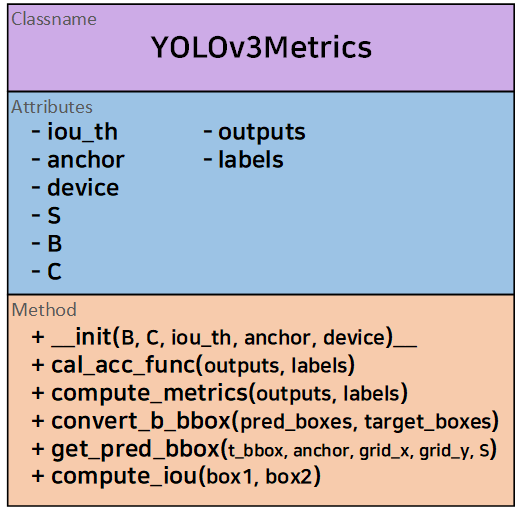

In [134]:
class YOLOv3Metrics:
    def __init__(self, B=3, C=80, iou_th = 0.5,
                 anchor=None, device='cuda'):
        self.B = B
        self.C = C
        self.device = device # 연산에 필요한 변수를 다 GPU로 올려야 함

        self.iou_th = iou_th
        # anchor 리스트 정보는 GPU로 올려야 함
        self.anchor = anchor.to(device) if anchor is not None else None

    def cal_acc_func(self, outputs, labels):
        # outputs, labels가 리스트 데이터 이기에
        # 원소별로 4가지 평가지표를 계산 후 덧셈한다.
        sum_iou = 0
        sum_precision = 0
        sum_recall = 0
        sum_top1_error = 0

        # outputs와 labels를 GPU로 이전
        self.outputs = [output.to(self.device) for output in outputs]
        self.labels = [label.to(self.device) for label in labels]

        # 리스트 내 원소가 0, 1, 2 3개니까 cnt는 0~2 를 순회한다.
        self.cnt = 0 # compute_metrics 함수 수행 전 cnt 초기화

        # 리스트 내 원소들을 추출한 후 연산 수행
        for output, label in zip(self.outputs, self.labels):
            # 실제 원소별 평가지표 연산은 `compute_metrics`함수에서 수행
            element_metrics = self.compute_metrics(output, label)

            sum_iou += element_metrics[0]
            sum_precision += element_metrics[1]
            sum_recall += element_metrics[2]
            sum_top1_error += element_metrics[3]

            self.cnt += 1

        iou = sum_iou / self.cnt if self.cnt > 0 else 0
        precision = sum_precision / self.cnt if self.cnt > 0 else 0
        recall = sum_recall / self.cnt if self.cnt > 0 else 0
        top1_error = sum_top1_error / self.cnt if self.cnt > 0 else 0

        # YOLOv3Metrics클래스의 최종 리턴값이라 보면 된다.
        cal_res = [iou, precision, recall, top1_error]
        return cal_res


    def compute_metrics(self, output, label):
        # Assert 구문을 활용하여 grid cell의 크기가 동일한지 확인
        assert output.size(1) == label.size(2), "그리드셀 차원이 맞지 않음"

        batch_size = output.size(0) # Batch_size의 사이즈정보
        S = output.size(2) # grid cell크기정보 추출

        # 원소의 차원은 [batch_size, S, S, Bx(5+C)] 4차원으로 되어있음
        # 이걸 [batch_size, S, S, B, 5+C] 5차원으로 차원전환
        predictions = output.view(batch_size, S, S, self.B, 5 + self.C)
        target = label.view(batch_size, S, S, self.B, 5 + self.C)

        # BBox정보 추출(tx, ty, tw, th) + OS정보도 포함시킴
        # 따라서 [batch_size, S, S, B, 5]
        pred_boxes = predictions[..., :5]
        target_boxes = target[..., :5]

        # BBox의 [tx, ty, tw, th] -> [bx, by, bw, bh]로 좌표변환
        b_pred_boxes, b_target_boxes = self.convert_b_bbox(pred_boxes, target_boxes)
        # 좌표변환된 b_pred_boxes, b_target_boxes의 차원은
        # pred_boxes, target_boxes에서 OS정보만 빠짐 [batch_size, S, S, B, 4]

        # 1번 평가지표 = 원소 IOU연산하기
        # 입력차원 : [batch_size, S, S, B, 4]
        ious = self.compute_iou(b_pred_boxes, b_target_boxes)
        iou_score = ious.mean().item()

        # IOU 임계값을 이용하여 TP, FP, FN 계산
        pred_os = (ious > self.iou_th).float()
        target_os = (target_boxes[..., 4] > 0).float()
        TP = (pred_os * target_os).sum().item()
        FP = (pred_os * (1 - target_os)).sum().item()
        FN = ((1 - pred_os) * target_os).sum().item()

        # 2,3번 평가지표 원소 정밀도(precision), 원소 재현율(recall) 계산
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0

        # 클래스 확률 정보(Class Probability) 추출 후 차원전환
        # [Batch_size, S, S, C] -> [Batch_size*S*S, C]
        # 원래는 pred_cp에 sigmoid를 적용해야 하나 패스...
        pred_cp = predictions[..., 5:].reshape(-1, self.C)
        target_cp = target[..., 5:].reshape(-1, self.C)

        # Softmax 적용 -> pred만 적용하면 됨
        pred_cp = F.softmax(pred_cp, dim=1)

        # Class 확률 정보에서 가장 높은 값을 갖는 idx 정보 추출
        pred_classes = torch.argmax(pred_cp, dim=1)
        target_classes = torch.argmax(target_cp, dim=1)
        # 추출 결과물은 [Batch_size*S*S] 1차원이 된다.

        # 객체가 아에 검출되지 않는 예외현상을 처리하는 구문
        non_zero_mask = target_classes != 0
        f_pred_classes = pred_classes[non_zero_mask]
        f_target_classes = target_classes[non_zero_mask]

        # 4번 평가지표 원소 Top-1 Error 계산
        top1_error = (~f_pred_classes.eq(f_target_classes)).float().mean().item()

        #원소 평가지표 4가지를 리턴
        element_metrics = [iou_score, precision, recall, top1_error]
        return element_metrics

    # [tx, ty, tw, th] -> [bx, by, bw, bh]의 수행을 준비하는 함수
    def convert_b_bbox(self, pred_boxes, target_boxes):
        # 마스크 필터 생성하기(yolo v3 Loss와 동일한 방식
        target_obj = target_boxes[..., 4]
        coord_mask = target_obj > 0
        noobj_mask = target_obj <= 0
        #예외처리 구문
        if coord_mask.sum() == 0:
            b_pred_boxes = torch.zeros_like(pred_boxes[..., :4])
            b_target_boxes = torch.zeros_like(target_boxes[..., :4])
            return b_pred_boxes, b_target_boxes

        # 필터링의 응용 -> 의미없는 셀을 탈락시키지 말고 0으로 치환하기
        pred_boxes[noobj_mask] = 0
        target_boxes[noobj_mask] = 0

        S = pred_boxes.size(1)
        # 그리드 셀의 idx를 저장용 매쉬 그리드 행렬 생성
        # 이 매쉬 그리드는 글로 설명하긴 어려운데 아무튼 idx을 저장하는 효율적인 행렬이다
        grid_x, grid_y = torch.meshgrid(torch.arange(S), torch.arange(S), indexing='xy')
        grid_x = grid_x.to(self.device).float()
        grid_y = grid_y.to(self.device).float()
        # 생성한 매쉬그리드는 CPU에 할당되서 GPU로 이전을 꼭 시켜줘야함

        # 모델의 예측값 tx, ty는 사전에 sigmoid를 적용한다.
        pred_boxes[..., 0] = torch.sigmoid(pred_boxes[..., 0])
        pred_boxes[..., 1] = torch.sigmoid(pred_boxes[..., 1])
        # [tx, ty, tw, th] -> [bx, by, bw, bh]의 실제 변환은 이 함수에서 수행됨
        b_pred_boxes = self.get_pred_bbox(pred_boxes, self.anchor, grid_x, grid_y, S)
        # [t*x, t*y, t*w, t*h] -> [b*x, b*y, b*w, b*h]의 실제 변환은 이 함수에서 수행됨
        b_target_boxes = self.get_pred_bbox(target_boxes, self.anchor, grid_x, grid_y, S)

        return b_pred_boxes, b_target_boxes

    # [tx, ty, tw, th] -> [bx, by, bw, bh]변환을 실제로 수행하는 함수
    # [t*x, t*y, t*w, t*h] -> [b*x, b*y, b*w, b*h]변환을 실제로 수행하는 함수
    def get_pred_bbox(self, t_bbox, anchor, grid_x, grid_y, S):
        # 여기에 들어오는 [tx], [ty], [tw], [th]는 모두
        # [Batch_size, S, S, B] 형태임 -> B : [anchor1, 2, 3]
        tx, ty = t_bbox[..., 0], t_bbox[..., 1]
        tw, th = t_bbox[..., 2], t_bbox[..., 3]

        # cnt는 작은 -> 중간 -> 큰 객체의 리스트를 순환하는 변수고
        # anchor box list에서 cnt 값에 맞춰 객체 크기용
        # box [3x2]를 가져옴 -> [3(B)], [3(B)]으로 나눠가짐
        pw, ph = anchor[self.cnt][..., 0], anchor[self.cnt][..., 1]

        # meshgrid로 정의된 grid_x, grid_x는 모두 [S, S]차원을 가짐
        # [S, S] -> [1, S, S, 1] -> [batch_size, S, S, C+5]로 차원확장
        grid_x = grid_x.unsqueeze(0).unsqueeze(-1).expand_as(tx)
        grid_y = grid_y.unsqueeze(0).unsqueeze(-1).expand_as(ty)

        # grid / s -> 이것은 그리드셀의 좌상돤 좌표값이 됨(cx, cy)
        # tx, ty는 sigmoid처리돤 c_pos와 b_pos의 '상대적인 거리'
        # 모두 정규화 좌표평면이니 t_pos도 1/s 처리 해줘야함
        bx = (tx + grid_x) / S
        by = (ty + grid_y) / S

        bw = pw * torch.exp(tw)
        bh = ph * torch.exp(th)
        # 좌표변환이 완료된 [bx, by, bw, bh]은 스택으로 쌓아서 return
        b_bbox = torch.stack([bx, by, bw, bh], dim=-1)
        return b_bbox

    # iou계산
    def compute_iou(self, box1, box2):
        box1_x1 = box1[..., 0] - box1[..., 2] / 2
        box1_y1 = box1[..., 1] - box1[..., 3] / 2
        box1_x2 = box1[..., 0] + box1[..., 2] / 2
        box1_y2 = box1[..., 1] + box1[..., 3] / 2

        box2_x1 = box2[..., 0] - box2[..., 2] / 2
        box2_y1 = box2[..., 1] - box2[..., 3] / 2
        box2_x2 = box2[..., 0] + box2[..., 2] / 2
        box2_y2 = box2[..., 1] + box2[..., 3] / 2

        inter_x1 = torch.max(box1_x1, box2_x1)
        inter_y1 = torch.max(box1_y1, box2_y1)
        inter_x2 = torch.min(box1_x2, box2_x2)
        inter_y2 = torch.min(box1_y2, box2_y2)

        inter_area = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)
        box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
        box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
        union_area = box1_area + box2_area - inter_area

        return inter_area / union_area

In [135]:
metrics = YOLOv3Metrics(anchor=anchor_box_list, device=device.type)
metrics

### Train / Val 함수 설계

In [ ]:
from tqdm import tqdm #훈련 진행상황 체크

#tqdm 시각화 도구 출력 사이즈 조절 변수
epoch_step = 2

In [ ]:
def model_train(model, data_loader,
                loss_fn, optimizer_fn, scheduler_fn,
                processing_device, epoch):
    model.train()  # 모델을 훈련 모드로 설정

    global epoch_step

    # loss와 accuracy를 계산하기 위한 임시 변수를 생성
    run_size, run_loss, = 0, 0
    #Yolo v1의 성능지표는 아래의 4개 항목으로 출력된다.
    #이때 성능지표는 이동평균 필터로 계산한다.
    avg_iou, avg_precision, avg_recall, avg_top1_error = 0, 0, 0, 0
    n = 0  # 값의 개수

    # 특정 에폭일 때만 tqdm 진행상황 바 생성
    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        progress_bar = tqdm(data_loader)
    else:
        progress_bar = data_loader

    # label은 리스트이니 labels로 이름변경함
    for image, labels in progress_bar:
        # 입력된 데이터를 먼저 GPU로 이전하기
        image = image.to(processing_device)
        # 라벨이 리스트 정보이기에 한개씩 떼어낸다.
        labels = [label.to(processing_device) for label in labels]

        # 전사 과정 수행
        outputs = model(image)
        # 여기서 출력되는 outputs도 리스트 -> 그리고 원소의 차원위치 변환해줘야함
        # [batch_size,(C+5),S,S] 출력을 [batch_size,S,S,(C+5)]로 변환
        outputs = [output.permute(0, 2, 3, 1) for output in outputs]

        loss = 0
        # 원소별 output, label에 대한 원소별 손실을 구한 뒤 합산
        for output, label in zip(outputs, labels):
            loss_elemnet = loss_fn(output, label)
            loss += loss_elemnet

        #backward과정 수행
        optimizer_fn.zero_grad()
        loss.backward()
        optimizer_fn.step()

        # 스케줄러 업데이트
        scheduler_fn.step()

        #현재까지 수행한 loss값을 얻어냄
        run_loss += loss.item() * image.size(0)
        run_size += image.size(0)

        #성능지표 계산하기 -> 리스트이니 outputs, labels임을 유의하자.
        metric_res = metrics.cal_acc_func(outputs, labels)
        iou_score, precision, recall, top1_error = metric_res
        # 이동평균 필터로 성능지표 계산하기
        n += 1
        avg_iou = avg_iou + (iou_score - avg_iou) / n
        avg_precision = avg_precision + (precision - avg_precision) / n
        avg_recall = avg_recall + (recall - avg_recall) / n
        avg_top1_error = avg_top1_error + (top1_error - avg_top1_error) / n

        #tqdm bar에 추가 정보 기입
        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            desc = (f"[훈련중] Loss: {run_loss / run_size:.2f}, "
                    f"KPI: [{avg_iou:.3f}, {avg_precision:.3f}, "
                    f"{avg_recall:.3f}, {avg_top1_error:.3f}]")
            progress_bar.set_description(desc)

    # avg_accuracy = correct / len(data_loader.dataset)
    avg_loss = run_loss / len(data_loader.dataset)
    avg_KPI = [avg_iou, avg_precision, avg_recall, avg_top1_error]
    return avg_loss, avg_KPI

In [ ]:
def model_evaluate(model, data_loader, loss_fn,
                   processing_device, epoch):
    model.eval()  # 모델을 평가 모드로 전환 -> dropout 기능이 꺼진다
    # batchnormalizetion 기능이 꺼진다.
    global epoch_step

    # 초기값 설정
    run_loss = 0
    avg_iou, avg_precision, avg_recall, avg_top1_error = 0, 0, 0, 0
    n = 0  # 값의 개수

    # gradient 업데이트를 방지해주자
    with torch.no_grad():

        # 특정 에폭일 때만 tqdm 진행상황 바 생성
        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            progress_bar = tqdm(data_loader)
        else:
            progress_bar = data_loader

        for image, labels in progress_bar:  # 이때 사용되는 데이터는 평가용 데이터
            # 입력된 데이터를 먼저 GPU로 이전하기
            image = image.to(processing_device)
            # 라벨이 리스트 정보이기에 한개씩 떼어낸다.
            labels = [label.to(processing_device) for label in labels]

            # 평가 결과를 도출하자
            outputs = model(image)
            # 여기서 출력되는 outputs도 리스트 -> 그리고 원소의 차원위치 변환해줘야함
            # [batch_size,(C+5),S,S] 출력을 [batch_size,S,S,(C+5)]로 변환
            outputs = [output.permute(0, 2, 3, 1) for output in outputs]

            loss = 0
            # 원소별 output, label에 대한 원소별 손실을 구한 뒤 합산
            for output, label in zip(outputs, labels):
                loss_elemnet = loss_fn(output, label)
                loss += loss_elemnet

            # 배치의 실제 크기에 맞추어 손실을 계산
            run_loss += loss.item() * image.size(0)

            #성능지표 계산하기 -> 리스트이니 outputs, labels임을 유의하자.
            metric_res = metrics.cal_acc_func(outputs, labels)
            iou_score, precision, recall, top1_error = metric_res

            # 이동평균 계산
            n += 1
            avg_iou = avg_iou + (iou_score - avg_iou) / n
            avg_precision = avg_precision + (precision - avg_precision) / n
            avg_recall = avg_recall + (recall - avg_recall) / n
            avg_top1_error = avg_top1_error + (top1_error - avg_top1_error) / n

        # accuracy = correct / len(data_loader.dataset)
        avg_loss = run_loss / len(data_loader.dataset)
        avg_KPI = [avg_iou, avg_precision, avg_recall, avg_top1_error]
        return avg_loss, avg_KPI

In [ ]:
# 모델 초기화(backbone는 사전학습모델 로드)
backbone = Darknet53(pretrained=True).to(device)
fpn = FPN(channels_list=features_shape).to(device)
model = YOLOv3(backbone, fpn, num_classes=80).to(device)

metrics = YOLOv3Metrics(anchor=anchor_box_list,device=device.type)

In [ ]:
# 백본 파라미터 Freeze
for param in backbone.parameters():
    param.requires_grad = False

In [ ]:
from torch import optim


criterion = Yolov3Loss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10,gamma=0.1)

In [ ]:
# 학습과 검증 손실 및 정확도를 저장할 리스트
his_loss = []
his_KPI = []
num_epoch = 30

for epoch in range(num_epoch):
    # 훈련 손실과 훈련 성과지표를 반환 받습니다.
    train_loss, train_KPI = model_train(model, train_loader,
                                        criterion, optimizer, scheduler,
                                        device, epoch)

    # 검증 손실과 검증 성과지표를 반환 받습니다.
    test_loss, test_KPI = model_evaluate(model, test_loader,
                                         criterion, device, epoch)

    # 손실과 성능지표를 리스트에 저장
    his_loss.append((train_loss, test_loss))
    his_KPI.append((train_KPI, test_KPI))

    # epoch가 특정 배수일 때만 출력하기
    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        print(f"epoch {epoch+1:03d}," + "\t" +
              f"Training loss: {train_loss:.4f}")
        print(f"Train KPI[ IOU: {train_KPI[0]:.4f}, "+
              f"Precision: {train_KPI[1]:.4f}, "+
              f"Recall: {train_KPI[2]:.4f}, "+
              f"Top1_err: {train_KPI[3]:.4f} ]")
        print(f"epoch {epoch+1:03d}," + "\t" +
              f"Test loss: {test_loss:.4f}")
        print(f"Test KPI[ IOU: {test_KPI[0]:.4f}, "+
              f"Precision: {test_KPI[1]:.4f}, "+
              f"Recall: {test_KPI[2]:.4f}, "+
              f"Top1_err: {test_KPI[3]:.4f} ]")
        # 중간 저장
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'his_loss': his_loss,
            'his_KPI': his_KPI
        }, root_dir.format(epoch + 1))

        print(f"Checkpoint saved at epoch {epoch+1}")

[훈련중] Loss: 293995.52, KPI: [0.748, 0.001, 0.076, 0.987]:  98%|█████████▊| 1247/1266 [8:29:28<07:46, 24.53s/it]

In [ ]:
# 학습 완료 후 모델 저장
torch.save(model.state_dict(), os.path.join(root_dir, "final_model.pth"))

# 손실과 성능지표 저장
with open(os.path.join(root_dir, 'final_loss_kpi.txt'), 'w') as f:
    f.write(f"Final Training loss: {his_loss[-1][0]:.4f}, Final Test loss: {his_loss[-1][1]:.4f}\n")
    f.write(f"Final Train KPI[ IOU: {his_KPI[-1][0][0]:.4f}, "+
            f"Precision: {his_KPI[-1][0][1]:.4f}, "+
            f"Recall: {his_KPI[-1][0][2]:.4f}, "+
            f"Top1_err: {his_KPI[-1][0][3]:.4f} ]\n")
    f.write(f"Final Test KPI[ IOU: {his_KPI[-1][1][0]:.4f}, "+
            f"Precision: {his_KPI[-1][1][1]:.4f}, "+
            f"Recall: {his_KPI[-1][1][2]:.4f}, "+
            f"Top1_err: {his_KPI[-1][1][3]:.4f} ]\n")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#histroy는 [train, test] 순임
#KPI는 [iou, precision, recall, top1_error] 순임
np_his_loss = np.array(his_loss)
np_his_KPI = np.array(his_KPI)

# his_loss에서 손실 데이터 추출
train_loss, val_loss = np_his_loss[..., 0], np_his_loss[..., 1]

# his_KPI에서 각 성능 지표 추출
train_iou, val_iou = np_his_KPI[..., 0, 0], np_his_KPI[..., 1, 0]
train_precision, val_precision = np_his_KPI[..., 0, 1], np_his_KPI[..., 1, 1]
train_recall, val_recall = np_his_KPI[..., 0, 2], np_his_KPI[..., 1, 2]
train_top1_errors, val_top1_errors = np_his_KPI[..., 0, 3], np_his_KPI[..., 1, 3]

# 2x3 플롯 설정
plt.figure(figsize=(10, 5))

# Train-Val Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train-Val Loss')

# Train-Val Top-1 Error
plt.subplot(1, 2, 2)
plt.plot(train_top1_errors, label='Train Top-1 Error')
plt.plot(val_top1_errors, label='Val Top-1 Error')
plt.xlabel('Training Epochs')
plt.ylabel('Top-1 Error')
plt.legend()
plt.title('Train-Val Top-1 Error')

plt.tight_layout()
plt.show()


plt.figure(figsize=(16, 6))

# IOU
plt.subplot(1, 3, 1)
plt.plot(train_iou, label='Train IOU')
plt.plot(val_iou, label='Val IOU')
plt.xlabel('Training Epochs')
plt.ylabel('IOU')
plt.legend()
plt.title('IOU')

# Precision
plt.subplot(1, 3, 2)
plt.plot(train_precision, label='Train Precision')
plt.plot(val_precision, label='Val Precision')
plt.xlabel('Training Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision')

# Recall
plt.subplot(1, 3, 3)
plt.plot(train_recall, label='Train Recall')
plt.plot(val_recall, label='Val Recall')
plt.xlabel('Training Epochs')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall')

plt.tight_layout()
plt.show()

In [ ]:
# 최종 AP 계산 함수
def calculate_ap(precisions, recalls):
    """AP를 계산하는 함수."""
    precisions = np.array(precisions)
    recalls = np.array(recalls)

    # Precision과 Recall 쌍 정렬
    sorted_indices = np.argsort(recalls)
    precision_sorted = precisions[sorted_indices]
    recall_sorted = recalls[sorted_indices]

    # AP 계산
    ap = 0.0
    for i in range(1, len(precision_sorted)):
        ap += (recall_sorted[i] - recall_sorted[i - 1]) * precision_sorted[i]

    return ap

# AP 계산
train_ap = []
test_ap = []
train_ap.append(calculate_ap(train_precision, train_recall))
test_ap.append(calculate_ap(val_precision, val_recall))
np.mean(train_ap),np.mean(test_ap)

### YOLOv3 NMS

In [136]:
import torch

# non_max_suppression과정은 YOLOv3Metrics의 함수를 재사용하자.
class Yolov3NMS(YOLOv3Metrics):
    def __init__(self, B=3, C=80, iou_th=0.4, conf_th=0.5):
        super().__init__(B, C, iou_th=iou_th, anchor=anchor_box_list)
        self.conf_th = conf_th #NMS의 첫번째 필터링 -> OS를 필터링하는 인자값

    # YOLOv3Metrics의 2개 함수 get_pred_bbox, compute_iou를 재사용한다.
    # get_pred_bbox는 재정의 해야함 -> 디바이스 문제...
    def get_pred_bbox(self, t_bbox, anchor, grid_x, grid_y, S):
        # 모든 텐서를 동일한 디바이스로 이동
        device = t_bbox.device
        anchor = anchor.to(device)
        grid_x = grid_x.to(device)
        grid_y = grid_y.to(device)

        # 여기에 들어오는 [tx], [ty], [tw], [th]는 모두 [Batch_size, S, S, B] 형태
        tx, ty = t_bbox[..., 0], t_bbox[..., 1]
        tw, th = t_bbox[..., 2], t_bbox[..., 3]

        # cnt는 작은 -> 중간 -> 큰 객체의 리스트를 순환하는 변수
        # anchor box list에서 cnt 값에 맞춰 객체 크기용 box [3x2]를 가져옴
        pw, ph = anchor[self.cnt][..., 0], anchor[self.cnt][..., 1]

        # meshgrid로 정의된 grid_x, grid_x는 모두 [S, S] 차원을 가짐
        # [S, S] -> [1, S, S, 1] -> [batch_size, S, S, B]로 차원 확장
        grid_x = grid_x.unsqueeze(0).unsqueeze(-1).expand_as(tx)
        grid_y = grid_y.unsqueeze(0).unsqueeze(-1).expand_as(ty)

        # grid / S -> 그리드셀의 좌상단 좌표값이 됨(cx, cy)
        # tx, ty는 sigmoid 처리된 c_pos와 b_pos의 '상대적인 거리'
        # 모두 정규화 좌표 평면이니 t_pos도 1/S 처리 해줘야 함
        bx = (tx + grid_x) / S
        by = (ty + grid_y) / S

        bw = pw * torch.exp(tw)
        bh = ph * torch.exp(th)

        # 좌표 변환이 완료된 [bx, by, bw, bh]은 스택으로 쌓아서 return
        b_bbox = torch.stack([bx, by, bw, bh], dim=-1)
        return b_bbox

    def compute_iou(self, box1, box2):
        return super().compute_iou(box1, box2)

    # NMS를 수행하는 준비과정인 데이터 추출 및 필터링 함수
    def process_predictions(self, pred):
        # 데이터 차원 배치 재정렬 하기
        pred = pred.permute(0, 2, 3, 1)
        assert pred.size(1) == pred.size(2), "데이터 정렬 오류"

        bs = pred.size(0)
        S = pred.size(1)

        # [batch_size, S, S, B*(C+5)]-> [batch_size, S, S, B, (C+5)]
        prediction = pred.view(bs, S, S, self.B, -1)

        # tx, ty, OS(objectness score), CP(class probability 항목에 sigmoid 적용
        prediction[..., :2] = torch.sigmoid(prediction[..., :2])  # t_x, t_y
        prediction[..., 4:] = torch.sigmoid(prediction[..., 4:])  # OS, CP

        t_bboxes = prediction[..., :4] #[batch_size, S, S, B, 4]
        obj_score = prediction[..., 4] #[batch_size, S, S, B]
        cp_score = prediction[..., 5:] #[batch_size, S, S, B, C]

        # 그리드셀 좌표 색인을 위한 매쉬그리드 데이터 생성
        grid_y, grid_x = torch.meshgrid(torch.arange(S), torch.arange(S), indexing='ij')

        # [tx, ty, tw, th] -> [bx, by, bw, bh] 변환 실행
        b_bboxes = self.get_pred_bbox(t_bboxes, self.anchor, grid_x, grid_y, S)

        # OS 정보를 conf_th로 필터링 (1차)
        # 각각 마스크 필터를 통과하여 [N, ~~] 차원으로 변환된다.
        conf_mask = obj_score > self.conf_th
        b_bboxes = b_bboxes[conf_mask] # [N, 4]
        obj_score = obj_score[conf_mask] # [N]
        cp_score = cp_score[conf_mask] # [N, C]

        # class confidence 곱하기
        # 이때 obj_score는 broadcasting이 안되기에 맨 뒤에 차원 추가
        cp_score *= obj_score.unsqueeze(-1)

        # 클래스와 스코어 정보로 필터링(2차)
        cp_val, cp_idx = torch.max(cp_score, -1)
        conf_mask = cp_val > self.conf_th
        b_bboxes = b_bboxes[conf_mask]
        cp_val = cp_val[conf_mask]
        cp_idx = cp_idx[conf_mask]

        return b_bboxes, cp_val, cp_idx

    # 필터링 + 내림차순을 거친 데이터를 기반으로 의미있는 bbox만 선택
    def apply_nms(self, b_bboxes, cp_val, cp_idx):
        keep_boxes = []
        while b_bboxes.size(0):
            # 신뢰도값이 가장 큰 단 1개의 데이터만 추출
            chosen_box = b_bboxes[0].unsqueeze(0) #[1, 4]
            chosen_val = cp_val[0].unsqueeze(0).unsqueeze(0) #[1, 1]
            chosen_idx = cp_idx[0].unsqueeze(0).unsqueeze(0) #[1, 1]

            keep_boxes.append(torch.cat((chosen_box, chosen_val, chosen_idx), dim=-1))
            if b_bboxes.size(0) == 1:
                break

            # 신뢰도값이 가장 큰 box랑 나머지 bbox를 비교하여 iou 연산
            # 연산하여 iou가 겹치는 bbox 항목을 제거한다.
            ious = self.compute_iou(chosen_box, b_bboxes[1:])
            b_bboxes = b_bboxes[1:][ious < self.iou_th]
            cp_val = cp_val[1:][ious < self.iou_th]
            cp_idx = cp_idx[1:][ious < self.iou_th]
        return keep_boxes


    def non_max_suppression(self, outputs):
        f_b_bboxes = []
        f_cp_val = []
        f_cp_idx = []

        # outputs 리스트 정보를 원소로 분해
        for cnt, pred in enumerate(outputs):
            self.cnt = cnt # 리스트 순회값으로 cnt 초기화

            b_bboxes, cp_val, cp_idx = self.process_predictions(pred)
            f_b_bboxes.append(b_bboxes)
            f_cp_val.append(cp_val)
            f_cp_idx.append(cp_idx)

        # 리스트 원소를 concat하기
        nms_bboxes = torch.cat(f_b_bboxes, dim=0)
        nms_val = torch.cat(f_cp_val, dim=0)
        nms_idx = torch.cat(f_cp_idx, dim=0)

        # 내림차순 정렬(신뢰도가 큰 값이 맨 앞에 오게)
        sorted_indices = torch.argsort(-nms_val)
        nms_bboxes = nms_bboxes[sorted_indices]
        nms_val = nms_val[sorted_indices]
        nms_idx = nms_idx[sorted_indices]

        # NMS 적용
        res_boxes = self.apply_nms(nms_bboxes, nms_val, nms_idx)
        # 최종 출력되는 res boxes는
        # 1) 신뢰도 값이 가장 높은 boxes 정보이다.
        # 2) 그리고 서로 겹치지 않는다(iou로 필터링됨)

        # 마지막에 출력되는 res_boxes의 원소값은 모두 [1,6]형태이니 [6]으로 차원축소
        # [bbox좌표, 신뢰도값, 클래스 id] 순이다.
        res_boxes = [box.squeeze(0) for box in res_boxes]

        return res_boxes

In [ ]:
# 디버깅을 위한 nms_debug 함수
def nms_debug():
    S_list = [52, 26, 13]
    outputs = []

    for S in S_list:
        output = torch.rand(1, 255, S, S)
        outputs.append(output)

    nms = Yolov3NMS()
    boxes = nms.non_max_suppression(outputs)

    for box in boxes:
        print(box)
nms_debug()

### 모델 실행

In [ ]:
import torch
import os

# 모델 불러오기
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

backbone = Darknet53(pretrained=True).to(device)
fpn = FPN(channels_list=features_shape).to(device)
model = YOLOv3(backbone, fpn, num_classes=80).to(device)

# model_weights = os.path.join(root_dir,'final_model.pth')
model_weights = os.path.join(root_dir,'Yolo_v3.pth')
model.load_state_dict(torch.load(model_weights))

In [ ]:
import cv2, random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [ ]:
from pycocotools.coco import COCO

root_dir = '/content/drive/MyDrive/COCO_DATASET'

anno_file = 'annotations/instances_val2014.json'
anno = COCO(os.path.join(root_dir, anno_file))

img_dir = os.path.join(root_dir, 'my_train_img')
img_info = anno.loadImgs(anno.getImgIds()[20])[0]
img_path = os.path.join(img_dir,img_info['file_name'])

In [ ]:
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image_rgb, (416, 416))
image_tensor = torch.from_numpy(image_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0

In [ ]:
# 모델 추론
with torch.no_grad():
    outputs = model(image_tensor)

# NMS 적용
nms = Yolov3NMS(conf_th=0.5)
boxes = nms.non_max_suppression(outputs)

# 추출된 bbox정보 display
for box in boxes:
    print(box)

In [ ]:
# 슈퍼 클래스와 해당 색상 매핑
cls_color = {
    "person": "magenta",
    "vehicle": "yellow",
    "outdoor": "blue",
    "animal": "green",
    "accessory": "purple",
    "sports": "orange",
    "kitchen": "brown",
    "food": "red",
    "furniture": "cyan",
    "electronic": "pink",
    "appliance": "lime",
    "indoor": "gray"
}

# COCO 클래스 레이블을 슈퍼 클래스에 따라 그룹화한 딕셔너리
coco_map = {
    "person": [0],
    "vehicle": [1, 2, 3, 4, 5, 6, 7],
    "outdoor": [8, 9, 10, 11, 12, 13],
    "animal": [14, 15, 16, 17, 18, 19, 20, 21, 22],
    "accessory": [23, 24, 25, 26, 27],
    "sports": [28, 29, 30, 31, 32, 33, 34, 35, 36, 37],
    "kitchen": [38, 39, 40, 41, 42, 43, 44],
    "food": [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55],
    "furniture": [56, 57, 58],
    "electronic": [59, 60, 61, 62, 63, 64],
    "appliance": [65, 66, 67, 68],
    "indoor": [69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
}

# COCO 클래스 레이블
coco_label = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train",
    "truck", "boat", "traffic light", "fire hydrant", "stop sign", "parking meter",
    "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear",
    "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase",
    "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
    "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
    "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake", "chair", "couch", "potted plant", "bed", "dining table", "toilet",
    "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave",
    "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase",
    "scissors", "teddy bear", "hair drier", "toothbrush"
]

In [ ]:
# 클래스 ID를 슈퍼 클래스 이름으로 매핑
cls_map = {cls_id: superclass for superclass, cls_ids in coco_map.items() for cls_id in cls_ids}

In [ ]:
# 결과 시각화 함수
def plot_boxes(image, boxes, labels):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    for box in boxes:
        x_center, y_center, w, h, conf, label = box
        # 중심 좌표와 크기를 좌상단, 우하단 좌표로 변환
        x1 = x_center - w / 2
        y1 = y_center - h / 2

        label = int(label)
        superclass = cls_map[label]
        color = cls_color[superclass]

        rect = Rectangle((x1, y1), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        plt.text(x1, y1, s=labels[label], color='black', verticalalignment='top',
                 bbox={'color': color, 'pad': 0})

    plt.axis('off')
    plt.show()

In [ ]:
# 원본 이미지로 시각화하기 위해 박스 좌표를 원래 이미지 크기로 변환
scale_y = image.shape[0] # height
scale_x = image.shape[1] # width

boxes = [[box[0] * scale_x, # x_center * width
          box[1] * scale_y, # y_center * height
          box[2] * scale_x, # w * width
          box[3] * scale_y, # h * height
          box[4], box[5]] for box in boxes]

In [ ]:
# 결과 시각화
plot_boxes(image_rgb, boxes, coco_label)